In [1]:
import sys
sys.path.append('/home/lpodgorsek/mag/scripts')

from relationGraph import Relation, RelationGraph, MatrixOfRelationGraph
from autoencoder import seedy, AutoEncoder
import utilityFunctions as uf
from main import test_build_relation_graph_with_symertic_data, test_convert_graph_to_2D_matrix, test_get_matix_for_autoencoder, test_autoencoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from base import load_source
from base2 import load_dicty, load_pharma
import utilityFunctions as uf
import autoencoder as ae
import multimodal as mm


from os.path import join
import numpy as np
import pandas as pd
import multiprocessing

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error
from fastcluster import linkage
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Layer, Reshape, UpSampling2D, Flatten, Masking, Dropout, concatenate, Conv2D, MaxPooling2D, BatchNormalization, Lambda
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, History
from tensorflow import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.utils import multi_gpu_model

In [2]:
def select_N_cells(data, num_of_cells):
    # data = (1,1024,128,1)
    # num_of_cells = 10
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    rand_vector = np.random.choice(np.flatnonzero(data_flatten), num_of_cells, replace=False)
    removed_cells = []
    
    for i in range(len(rand_vector)):
        v = data_flatten[rand_vector[i]]
        # removed_cells = [(100,1), (223, 1), (2244, 1), ...]
        removed_cells.append((rand_vector[i], v))
    return removed_cells

def save_test_cells(filename, data):
    f = uf.my_savez(filename)
    f.savez(data)
    f.close()
    
    
def load_test_cells(filename):
    f = np.load(filename)
    data = f[f.files[0]]
    new_data = []
    for line in data:
        new_data.append((int(line[0]), line[1]))
        
    return new_data


def remove_cells_from_data(data, list_of_cells):
    # data = (1,1024,128,1)
    # list_of_cells = [(111, 1.0), (2244, 0.34), ...]
    _,row,col,_ = data.shape
    data_flatten = data.flatten()
    for index, _ in list_of_cells:
        data_flatten[int(index)] = 0
        
    return data.reshape(1, row, col, 1)
        
    
    

def data_generator(filenames, org_data, batch_size=1, testing_cells=None, removed_cells=False):
    # n_pack => 1 samples of matrix
    # n_pack = batch_size
    # org_data = [[1,1024,128,1], [1,1024,256,1], [1,1024,1024,1]]
    # testing_cells = [[(111, 1.0), (2244, 0.34), ...], [(111, 1.0), (2244, 0.34), ...], ...]
    
    files = []              # different files
    num_packs = []          # subpacked inside of file
    for filename in filenames:
        f = np.load(filename)
        files.append(f)  
        num_packs.append(f.files)
    
    counter = 0
    while True:
        x = []
        y = []
        for i in range(len(files)):
            _x = []
            _y = []
            for j in range(batch_size):
                rand_num = np.random.randint(len(num_packs[i]))
                f = files[i]
                pack = num_packs[i]
                data = f[pack[rand_num]] 
                
                if testing_cells is not None and removed_cells:
                    data = remove_cells_from_data(data, testing_cells[i])

                _, row, col, _ = data.shape
                if col != 1021:
                    _x.append(f[pack[rand_num]])
                    _y.append(org_data[i])
            
            _x = np.asarray(_x)
            _y = np.asarray(_y)

            _x = _x[:, 0, :, :, :]
            _y = _y[:, 0, :, :, :]
        
            x.append(_x)
            y.append(_y)
            
        yield (x, y)
        
            
def top_N_rows(data, rows=100):
    _, row, col, _ = data.shape
    rows = row
    remove_col = col % 6
    data = data.reshape(row, col)
    new_data = data[:rows, :(col - remove_col)]
    return new_data.reshape(1, rows, col - remove_col, 1)
    
    
def shuffle_data(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        np.random.shuffle(tmp_data)  # shuffle org data
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data


def replace_and_shuffle_data_with_random(org_data):
    shufle_data = []
    for data in org_data:
        tmp_data = data
        _, row, col, _ = tmp_data.shape
        tmp_data = tmp_data.flatten()
        tmp_data[tmp_data > 0] = 1;   # set nonzero values to 1
        tmp_data = tmp_data * np.random.rand(len(tmp_data))  # multiply with random vecotor
        shufle_data.append(np.array(tmp_data).reshape(1, row, col, 1))

    return shufle_data

    
def order_inputs(model, org_data):
    new_order_data = []
    for inp in model.inputs:
        _, x, y, _ = inp.shape
        for data in org_data:
            _, row, col, _ = data.shape
            if x == row and y == col:
                new_order_data.append(np.array(data).reshape(1,row,col,1))
                break

    return new_order_data


def duplicateBatchData(data, batch=2):
    new_data = []
    for i in range(len(data)):
        b = []
        for j in range(batch):
            b.append(data[i])

        b = np.asarray(b)
        b = b[:,0,:,:,:]

        new_data.append(b)
        
    return new_data;

    
class MultiModal:
    
    def __init__(self, graph=None, path='', num_of_test_cells=10, load_test_cells=False):
        self.input_visibles = []
        self.input_layers = []
        self.outputs_layers = []
        self.input_data_size = []
        self.filenames = []
        self.inputs = None
        self.model = None
        self.path = path
        self.folder = path
        self.graph = graph
        self.org_data = []
        self.predict_data = []
        self.base_line = []
        self.shuffled_data = []
        self.dropout = 0.5
        self.num_of_saved_cells = num_of_test_cells
        self.saved_cells_for_test = []
        self.predict_saved_cells_for_test = []
        self.is_first_iteration = True
        self.fake_org_data = []
        self.activation = 'relu'
        self.load_test_cells = load_test_cells
        
        if graph is not None:
            self._read_graph(graph)
        self._callbacks()
        
        for i in range(len(self.org_data)):
            self.fake_org_data.append(remove_cells_from_data(self.org_data[i], self.saved_cells_for_test[i]))
                    
    def _read_graph(self, graph):
        already = set()
        for obj in graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self._set_params(relation)
                    already.add(relation.name)
                    
    def set_path_to_files(self, path):
        self.path = path
        self.filenames = []
        already = set()
        for obj in self.graph.objects.values():        
            for relation in obj.relation_x:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)

            for relation in obj.relation_y:
                if relation.name not in already:
                    self.filenames.append(self.path + relation.name + '.npz')
                    already.add(relation.name)
                    
    def set_path_to_folder(self, folder):
        self.folder = folder
                        
    def _set_params(self, relation):
        print(relation.name + '\t' + str(relation.matrix.shape))
        
        row, col = relation.matrix.shape
        
        data = np.array(relation.matrix).reshape(1,row,col,1)
#         new_data = top_N_rows(data)
        new_data = data
        _, new_r, new_c, _ = new_data.shape
        self.org_data.append(new_data)
        if self.load_test_cells == True:
            test_cells = load_test_cells(self.folder + 'samples_' + relation.name + '.npz')
            self.saved_cells_for_test.append(test_cells)
            self.num_of_saved_cells = len(test_cells)
        else:
            test_cells = select_N_cells(new_data, self.num_of_saved_cells)
            self.saved_cells_for_test.append(test_cells)
            save_test_cells(self.folder + 'samples_' + relation.name, test_cells)
        self.input_data_size.append((new_r, new_c))
        self._input_layer((new_r, new_c))
        self.filenames.append(self.path + relation.name + '.npz')
        
    def _input_layer(self, input_size):
        row, col = input_size
        visible = Input(shape=(row, col, 1))
#         Conv2D filtered by columns
        
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(visible)
#         layer = Conv2D(128, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(64, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(32, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
#         layer = Conv2D(16, (3, 3), activation='relu', padding='same')(layer)
        layer = MaxPooling2D((2, 2), padding='same')(layer)
        if col == 1024:
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
#             layer = Conv2D(8, (3, 3), activation='relu', padding='same')(layer)
#             layer = MaxPooling2D((2, 2), padding='same')(layer)
            
        layer = Flatten()(layer)
        layer = Dense(1024, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(128, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(64, activation=self.activation)(layer)
        
        self.input_layers.append(layer)
        self.input_visibles.append(visible)
    
    def _output_layer(self, input_size):
        row, col = input_size
        layer = None
        
        if col == 128:
            layer = Reshape((64, 8, 2))(self.inputs)
        elif col == 256:
            layer = Reshape((64, 16, 1))(self.inputs)
        elif col == 1024:
            layer = Reshape((32, 32, 1))(self.inputs)
            layer = Conv2D(8, (3, 3), activation=self.activation, padding='same')(layer)
            layer = UpSampling2D((2, 2))(layer)
        
        layer = Conv2D(16, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(32, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(64, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(128, (3, 3), activation=self.activation, padding='same')(layer)
        layer = UpSampling2D((2, 2))(layer)
        layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(layer)

        self.outputs_layers.append(layer)
        
    def _decoder(self):
        layer = Dense(128, activation=self.activation)(self.inputs)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(256, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(512, activation=self.activation)(layer)
        layer = Dropout(self.dropout)(layer)
        layer = Dense(1024, activation=self.activation)(layer) 
        self.inputs = layer
        
    def _callbacks(self):
        log_dir = '/home/lpodgorsek/data/logs/'
        self.callbacks = [
            TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)
#             EarlyStopping(monitor='loss', min_delta=0, patience=3, verbose=0, mode='auto'),
            
        ]
        
    def build_model(self, optimizer='sgd', loss='mse', metrics=['mae', 'acc'], gpu=1):
        self.inputs = concatenate(self.input_layers)
        self.inputs = Dense(64, activation=self.activation)(self.inputs) 
#         layer = concatenate(self.input_layers)
#         layer = Dense(512, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(256, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(128, activation=self.activation)(layer)
#         layer = Dropout(self.dropout)(layer)
#         layer = Dense(64, activation=self.activation)(layer)
#         self.inputs = layer
        self._decoder()

        [self._output_layer(data_size) for data_size in self.input_data_size]
        
        self.model = Model(inputs=self.input_visibles, outputs=self.outputs_layers)
        
        try:
            with tf.device('/cpu:0'):
                self.model = multi_gpu_model(self.model, gpus=gpu, cpu_merge=True, cpu_relocation=True)
        except e:
            print(e)
            pass
        
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
        self.model.summary()
        
    def fit(self, batch_size, epochs):
        self.batch_size = batch_size;
        self.model.fit_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size, self.saved_cells_for_test, self.is_first_iteration), 
            steps_per_epoch=batch_size, 
            epochs=epochs,
            callbacks=self.callbacks
        )
        self.is_first_iteration = False
        
    def save(self, path, version):
        self.model.save(path + 'experiment_' + version + '.h5')

    def load_model(self, path, version):
        self.model = load_model(path + 'experiment_' + version + '.h5')
        
    def predict_hidden_cells(self, display_cells=None):
        list_of_predict = {}
            
        if display_cells is None or display_cells > len(self.saved_cells_for_test[0]):
            display_cells = len(self.saved_cells_for_test[0])
            
        print()
        print("Predict Original Diff \t\tPredict Original Diff \t\tPredict Original Diff")
        print("---------------------------------------------------------------------------------------")
        avg_diff = np.zeros(len(self.saved_cells_for_test))
        for i in range(len(self.saved_cells_for_test[0][:display_cells])):
            for j in range(len(self.saved_cells_for_test)):
                idx, val = self.saved_cells_for_test[j][i]
                predict_val = self.predict_data[j].flatten()[idx]
                diff_abs = np.abs(self.predict_data[j].flatten()[idx] - val)
                avg_diff[j] += diff_abs
                
                if j not in list_of_predict:
                    list_of_predict[j] = [(idx, predict_val)] 
                else:
                    list_of_predict[j].append((idx, predict_val)) 
                print(str(self.saved_cells_for_test[j][i]) + ' ' + format(predict_val, '.5f') + ' ' + format(val, '.5f') + ' ' + format(diff_abs, '.5f'), end=" \t")
            print()
        print("---------------------------------------------------------------------------------------")

        for i in range(len(avg_diff)):
            val = avg_diff[i]*100/len(self.saved_cells_for_test[0][:display_cells])
            print("\t\t" + format(val, '.5f') + "%", end="\t")
        print()
        
        for i in range(len(list_of_predict)):
            self.predict_saved_cells_for_test.append(list_of_predict[i])
        
    def predict_generator(self, batch_size=10, iteration=1):
        predict = self.model.predict_generator(
            data_generator(self.filenames, self.fake_org_data, batch_size),
            steps=100
        )

        for i in range(len(self.org_data)):
            _,row, col,_ = predict[i].shape
            print(predict[i].shape)
            mse = 0
            for j in range(predict[i].shape[0]):
                mse += mean_squared_error(self.org_data[i].flatten(), predict[i][j].flatten())

            print('MSE' + str(i+1) + ': ' + format(mse*100/predict[i].shape[0], '.5f'))
            print()

            if col == 128:
                filename = self.folder + 'predict_' + str(iteration) + '_ann.npz'
            elif col == 256:
                filename = self.folder + 'predict_' + str(iteration) + '_expr.npz'
            elif col == 1024:
                filename = self.folder + 'predict_' + str(iteration) + '_ppi.npz'
            else:
                raise ValueError("ERROR: wrong data!!")
                
            f = uf.my_savez(filename)

            for j in range(predict[i].shape[0]):
                data = predict[i][j].reshape(1, row, col, 1)
                f.savez(data)
            f.close()
        
    def predict(self, random=False):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        self.predict_data = self.model.predict(self.org_data)
        self.base_line = self.model.predict(self.shuffled_data)
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
#         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
        for i in range(len(self.org_data)):
            _, row, col, _ = self.org_data[i].shape 
            mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
            mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())
            
            non_zeros = self.org_data[i].flatten()
            non_zeros[self.org_data[i].flatten() > 0] = 1
            org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
            predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)
            
            outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
            outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
            outputBody += str(round(mse * 100, 5)) + '% \t'
            outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
            outputBody += str(org_mean) + '\t\t'
            outputBody += str(predict_mean) + '\t\t'
            outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
            outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
            print(outputBody)
            
    def predictMultiGPU(self, random=False, gpu=1):
        self.org_data = order_inputs(self.model, self.org_data)
            
        if random == True:
            self.shuffled_data = replace_and_shuffle_data_with_random(self.org_data)
        else: 
            self.shuffled_data = shuffle_data(self.org_data)
            
        outputHeader = 'Data\t\t'
        outputHeader += 'Density\t\t'
        outputHeader += 'Predict\t\t'
        outputHeader += 'BaseLine\t'
        outputHeader += 'AVG Mean\t'
        outputHeader += 'Predict (mean)\t'
        outputHeader += 'Predict (min)\t'
        outputHeader += 'Predict (max)\t'
        print(outputHeader)
        
        if gpu == 1:
            self.predict_data = self.model.predict(self.org_data)
            self.base_line = self.model.predict(self.shuffled_data)

    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i].flatten(), self.predict_data[i].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i].flatten(), self.base_line[i].flatten())

                non_zeros = self.org_data[i].flatten()
                non_zeros[self.org_data[i].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i].flatten()), 5)) + '\t'
                print(outputBody)
                
        else:            
            self.predict_data = self.model.predict(duplicateBatchData(self.org_data, gpu))
            self.base_line = self.model.predict(duplicateBatchData(self.shuffled_data, gpu))
            
    #         print('Data \t\t\tDensity \tPredict \tBaseLine \tAVG Mean')
            for i in range(len(self.org_data)):
                _, row, col, _ = self.org_data[i].shape 
                mse = mean_squared_error(self.org_data[i][0].flatten(), self.predict_data[i][0].flatten())
                mse_base_line = mean_squared_error(self.shuffled_data[i][0].flatten(), self.base_line[i][0].flatten())

                non_zeros = self.org_data[i][0].flatten()
                non_zeros[self.org_data[i][0].flatten() > 0] = 1
                org_mean = round(np.mean(non_zeros * self.org_data[i][0].flatten()), 5)
                predict_mean = round(np.mean(non_zeros * self.predict_data[i][0].flatten()), 5)

                outputBody = '(' + str(row) + ',' + str(col) + ') ' + '\t'
                outputBody += str(round((np.count_nonzero(self.org_data[i][0])/(row * col)) * 100, 2)) + '% \t\t'
                outputBody += str(round(mse * 100, 5)) + '% \t'
                outputBody += str(round(mse_base_line * 100, 5)) + '% '+ '\t'
                outputBody += str(org_mean) + '\t\t'
                outputBody += str(predict_mean) + '\t\t'
                outputBody += str(round(min(self.predict_data[i][0].flatten()), 5)) + '\t\t'
                outputBody += str(round(max(self.predict_data[i][0].flatten()), 5)) + '\t'
                print(outputBody)

In [3]:
numOfExperiment = 'model_weigth'
epchos = 5
GPU = 3
batch_size = 3 * GPU
# path_data = '/data/samples/multiple_inputs_clustering/dicty/'
# folder = '/home/lpodgorsek/data/cnn/dicty/_00/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_05/'
    folder = '/home/lpodgorsek/data/cnn/dicty/_10/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_25/'
#     folder = '/home/lpodgorsek/data/cnn/dicty/_50/'
graph1 = load_dicty('clustering', 2)

model = MultiModal(graph=graph1, path=folder, num_of_test_cells=100, load_test_cells=False)
#     model.build_model(optimizer='sgd', loss='mse')
#     loss='binary_crossentropy'
model.build_model(optimizer='adadelta', loss='binary_crossentropy', metrics=['mae', 'acc'], gpu=GPU)
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 1)

model.set_path_to_files(folder + 'predict_1_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 2)

model.set_path_to_files(folder + 'predict_2_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()
model.predict_generator(batch_size, 3)

model.set_path_to_files(folder + 'predict_3_')
model.fit(batch_size, epchos)
model.save(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=GPU)
model.predict_hidden_cells()

In [3]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment) + '_1')
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		2.55483% 	6.96919% 	0.04888		0.02539		0.0		0.99997	
(1024,256) 	95.4% 		0.68738% 	6.38776% 	0.82382		0.80046		0.01812		0.88382	
(1024,1024) 	3.04% 		1.94647% 	2.28368% 	0.02452		0.00316		0.0002		0.35563	


In [4]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.88371 1.00000 0.11629 	(213910, 0.9037879560274013) 0.86636 0.90379 0.03743 	(688427, 0.938751472320377) 0.03369 0.93875 0.90506 	
(32635, 1.0) 0.85217 1.00000 0.14783 	(212974, 0.8941978001127759) 0.86390 0.89420 0.03030 	(4240, 0.9623085983510011) 0.19136 0.96231 0.77095 	
(2436, 1.0) 0.75291 1.00000 0.24709 	(44828, 0.8401417658060423) 0.81762 0.84014 0.02252 	(694929, 0.9799764428739693) 0.02392 0.97998 0.95606 	
(55808, 1.0) 0.90091 1.00000 0.09909 	(232148, 0.8783613613364569) 0.86669 0.87836 0.01168 	(600540, 0.5747938751472321) 0.03458 0.57479 0.54021 	
(44159, 1.0) 0.22060 1.00000 0.77940 	(106790, 0.8420843224691953) 0.84534 0.84208 0.00325 	(226406, 0.8680800942285042) 0.15279 0.86808 0.71529 	
(25344, 1.0) 0.94679 1.00000 0.05321 	(155900, 0.8219974944514251) 0.85551 0.82200 0.03351 	(122896, 0.99528857

(30605, 1.0) 0.52745 1.00000 0.47255 	(26153, 0.7452398860506029) 0.82838 0.74524 0.08314 	(157174, 1.0) 0.05390 1.00000 0.94610 	
(76288, 1.0) 0.99177 1.00000 0.00823 	(36157, 0.8362968225795768) 0.83981 0.83630 0.00351 	(20954, 0.9187279151943463) 0.10105 0.91873 0.81767 	
(26018, 1.0) 0.13462 1.00000 0.86538 	(28890, 0.8669332866269653) 0.85044 0.86693 0.01649 	(181702, 0.6819787985865724) 0.06805 0.68198 0.61393 	
(15488, 1.0) 0.95238 1.00000 0.04762 	(66509, 0.913707448314581) 0.86491 0.91371 0.04880 	(456980, 0.9316843345111897) 0.05524 0.93168 0.87645 	
(14846, 1.0) 0.75376 1.00000 0.24624 	(239031, 0.8851185499059595) 0.86975 0.88512 0.01537 	(475417, 0.8268551236749117) 0.04691 0.82686 0.77994 	
(32763, 1.0) 0.81242 1.00000 0.18758 	(74079, 0.8136985437118921) 0.84348 0.81370 0.02978 	(76897, 0.994110718492344) 0.21401 0.99411 0.78010 	
(3358, 1.0) 0.10453 1.00000 0.89547 	(162202, 0.9013164754350754) 0.85821 0.90132 0.04311 	(148632, 0.92226148409894) 0.16004 0.92226 0.76222 

(2813, 1.0) 0.70164 1.00000 0.29836 	(106336, 0.837155641146507) 0.85204 0.83716 0.01488 	(70064, 1.0) 0.06591 1.00000 0.93409 	
(57494, 1.0) 0.13688 1.00000 0.86312 	(127674, 0.8341266731748087) 0.84655 0.83413 0.01243 	(219145, 0.43934040047114253) 0.24412 0.43934 0.19522 	
(52733, 1.0) 0.97614 1.00000 0.02386 	(215375, 0.915671669561574) 0.85754 0.91567 0.05813 	(550003, 0.8881036513545347) 0.05499 0.88810 0.83312 	
(13193, 1.0) 0.24735 1.00000 0.75265 	(220183, 0.9147932322091735) 0.86920 0.91479 0.04560 	(14454, 0.9681978798586572) 0.20443 0.96820 0.76377 	
(60969, 1.0) 0.13459 1.00000 0.86541 	(238049, 0.8699697832692983) 0.87045 0.86997 0.00048 	(137272, 0.7915194346289753) 0.20691 0.79152 0.58461 	
(36741, 1.0) 0.45568 1.00000 0.54432 	(110609, 0.8160256395173594) 0.86027 0.81603 0.04424 	(386160, 0.9305064782096585) 0.04921 0.93051 0.88129 	
(4608, 1.0) 0.95011 1.00000 0.04989 	(22710, 0.9058076826195942) 0.84315 0.90581 0.06266 	(250951, 0.8539458186101296) 0.14982 0.85395 0.

(23134, 1.0) 0.03136 1.00000 0.96864 	(100918, 0.8146914596893262) 0.84621 0.81469 0.03152 	(108806, 0.9269729093050648) 0.09365 0.92697 0.83332 	
(51583, 1.0) 0.99072 1.00000 0.00928 	(147885, 0.918594242616171) 0.84356 0.91859 0.07503 	(127210, 0.04711425206124857) 0.08081 0.04711 0.03370 	
(71300, 1.0) 0.31048 1.00000 0.68952 	(161769, 0.8889750997549195) 0.85419 0.88898 0.03478 	(479439, 0.9316843345111897) 0.05148 0.93168 0.88021 	
(67713, 1.0) 0.32490 1.00000 0.67510 	(114369, 0.948370456114582) 0.84457 0.94837 0.10380 	(175119, 0.9976442873969376) 0.23262 0.99764 0.76503 	
(23831, 1.0) 0.19137 1.00000 0.80863 	(256541, 0.8888296102974736) 0.85165 0.88883 0.03718 	(203825, 0.9116607773851589) 0.19154 0.91166 0.72012 	
(9752, 1.0) 0.21309 1.00000 0.78691 	(17541, 0.7695029790757576) 0.71376 0.76950 0.05574 	(26981, 0.8362779740871614) 0.08360 0.83628 0.75268 	
(28683, 1.0) 0.20744 1.00000 0.79256 	(92349, 0.8329746862734568) 0.85123 0.83297 0.01825 	(391220, 0.7561837455830389) 0.

(45446, 1.0) 0.20278 1.00000 0.79722 	(67783, 0.8759594696412678) 0.86624 0.87596 0.00972 	(18458, 0.4534746760895171) 0.23233 0.45347 0.22114 	
(44605, 1.0) 0.04576 1.00000 0.95424 	(210907, 0.8546827162023052) 0.85699 0.85468 0.00231 	(212090, 0.9976442873969376) 0.09252 0.99764 0.90512 	
(644, 1.0) 0.66973 1.00000 0.33027 	(71641, 0.949059453998139) 0.84963 0.94906 0.09943 	(167098, 0.684334511189635) 0.16534 0.68433 0.51900 	
(6179, 1.0) 0.27733 1.00000 0.72267 	(213647, 0.8911479654055573) 0.86451 0.89115 0.02664 	(1049, 0.9575971731448765) 0.14495 0.95760 0.81265 	
(23120, 1.0) 0.05238 1.00000 0.94762 	(223455, 0.897868826237847) 0.85810 0.89787 0.03977 	(824565, 0.7938751472320377) 0.01736 0.79388 0.77652 	
(57031, 1.0) 0.09468 1.00000 0.90532 	(256244, 0.8877472124874322) 0.86381 0.88775 0.02394 	(42291, 0.8916372202591284) 0.09150 0.89164 0.80014 	
(21883, 1.0) 0.69400 1.00000 0.30600 	(142658, 0.9065764936914155) 0.85051 0.90658 0.05607 	(267560, 0.43816254416961126) 0.07241 

(1169, 1.0) 0.10571 1.00000 0.89429 	(216464, 0.8947124916843738) 0.85835 0.89471 0.03636 	(165345, 0.6643109540636043) 0.07556 0.66431 0.58875 	
(4095, 1.0) 0.79601 1.00000 0.20399 	(125701, 0.8139900045454769) 0.83981 0.81399 0.02582 	(431444, 0.20848056537102483) 0.05411 0.20848 0.15437 	
(6062, 1.0) 0.07430 1.00000 0.92570 	(138918, 0.8950615368937899) 0.85156 0.89506 0.04350 	(30831, 0.917550058892815) 0.18427 0.91755 0.73328 	
(36314, 1.0) 0.04288 1.00000 0.95712 	(130819, 0.894087551484103) 0.82873 0.89409 0.06536 	(193116, 0.9988221436984688) 0.03275 0.99882 0.96607 	
(130944, 1.0) 0.77000 1.00000 0.23000 	(87521, 0.8895858423424595) 0.84637 0.88959 0.04322 	(66651, 0.9670200235571261) 0.21504 0.96702 0.75198 	
(21636, 1.0) 0.38752 1.00000 0.61248 	(198645, 0.8425931096702185) 0.86088 0.84259 0.01829 	(361610, 0.4911660777385159) 0.09408 0.49117 0.39709 	
(2695, 1.0) 0.65296 1.00000 0.34704 	(136865, 0.8770121219023009) 0.85199 0.87701 0.02502 	(45056, 0.8162544169611308) 0.296

(4390, 1.0) 0.10953 1.00000 0.89047 	(127125, 0.8358503411308392) 0.85097 0.83585 0.01512 	(392444, 0.7962308598351) 0.06295 0.79623 0.73328 	
(53631, 1.0) 0.98299 1.00000 0.01701 	(215653, 0.9154732049195081) 0.86197 0.91547 0.05350 	(438752, 0.9658421672555949) 0.03791 0.96584 0.92793 	
(12297, 1.0) 0.31256 1.00000 0.68744 	(43376, 0.8571802693986659) 0.85257 0.85718 0.00461 	(273549, 0.9187279151943463) 0.06809 0.91873 0.85064 	
(6548, 1.0) 0.20138 1.00000 0.79862 	(158939, 0.8735458460279799) 0.84625 0.87355 0.02729 	(10422, 0.9988221436984688) 0.19399 0.99882 0.80484 	
(5143, 1.0) 0.16164 1.00000 0.83836 	(170467, 0.8895833554088719) 0.85825 0.88958 0.03134 	(55719, 0.26972909305064785) 0.06686 0.26973 0.20286 	
(13715, 1.0) 0.18539 1.00000 0.81461 	(62778, 0.8520190209890851) 0.85094 0.85202 0.00107 	(535118, 0.8833922261484101) 0.02733 0.88339 0.85606 	
(51708, 1.0) 0.80074 1.00000 0.19926 	(141248, 0.8381744808810675) 0.86643 0.83817 0.02825 	(129300, 0.44051825677267376) 0.144

(87172, 1.0) 0.99645 1.00000 0.00355 	(110766, 0.8223818998939938) 0.85529 0.82238 0.03291 	(104570, 0.9316843345111897) 0.15224 0.93168 0.77944 	
(38659, 1.0) 0.63709 1.00000 0.36291 	(10796, 0.7511975364267863) 0.01820 0.75120 0.73300 	(64582, 0.8445229681978799) 0.21504 0.84452 0.62949 	
(22931, 1.0) 0.17847 1.00000 0.82153 	(199589, 0.8570338589583322) 0.85266 0.85703 0.00437 	(141339, 0.8904593639575972) 0.21863 0.89046 0.67183 	
(40728, 1.0) 0.08919 1.00000 0.91081 	(58967, 0.8948085077716741) 0.81498 0.89481 0.07983 	(331249, 0.9976442873969376) 0.02740 0.99764 0.97025 	
(9121, 1.0) 0.14300 1.00000 0.85700 	(78993, 0.8379545623915988) 0.84410 0.83795 0.00614 	(266358, 0.6454652532391049) 0.08370 0.64547 0.56176 	
(114561, 1.0) 0.98993 1.00000 0.01007 	(31076, 0.8857689550393061) 0.85785 0.88577 0.02792 	(320744, 0.96113074204947) 0.06436 0.96113 0.89677 	
(87682, 1.0) 0.97894 1.00000 0.02106 	(239258, 0.8814854131309768) 0.86501 0.88149 0.01647 	(760629, 0.4758539458186102) 0.00

(76419, 1.0) 0.99412 1.00000 0.00588 	(262097, 0.8554801779160757) 0.64320 0.85548 0.21228 	(594115, 0.7267373380447586) 0.04865 0.72674 0.67809 	
(36995, 1.0) 0.39049 1.00000 0.60951 	(34992, 0.8202230969471466) 0.82898 0.82022 0.00875 	(358497, 0.7597173144876326) 0.06870 0.75972 0.69102 	
(10419, 1.0) 0.05088 1.00000 0.94912 	(223373, 0.9005183883602514) 0.87619 0.90052 0.02433 	(118983, 0.8881036513545347) 0.13302 0.88810 0.75508 	
(49532, 1.0) 0.96674 1.00000 0.03326 	(140182, 0.8393154904920529) 0.86024 0.83932 0.02092 	(189879, 0.7314487632508835) 0.06994 0.73145 0.66151 	
(68739, 1.0) 0.37052 1.00000 0.62948 	(70384, 0.8531100423492085) 0.83839 0.85311 0.01472 	(175122, 0.9976442873969376) 0.23000 0.99764 0.76764 	
(5922, 1.0) 0.20224 1.00000 0.79776 	(125236, 0.8379360155226823) 0.83392 0.83794 0.00402 	(68674, 0.7797408716136632) 0.21504 0.77974 0.56470 	
(7688, 1.0) 0.51067 1.00000 0.48933 	(54244, 0.9653793642545262) 0.83485 0.96538 0.13053 	(505033, 0.9517078916372204) 0.0

(55554, 1.0) 0.57317 1.00000 0.42683 	(152337, 0.8421854008294313) 0.82721 0.84219 0.01498 	(8246, 0.9823321554770318) 0.23235 0.98233 0.74999 	
(17814, 1.0) 0.18775 1.00000 0.81225 	(66124, 0.813256084527744) 0.81223 0.81326 0.00102 	(74892, 0.7703180212014135) 0.13011 0.77032 0.64021 	
(31744, 1.0) 0.99589 1.00000 0.00411 	(241602, 0.8841090115117414) 0.87097 0.88411 0.01314 	(36932, 0.5206124852767963) 0.21504 0.52061 0.30558 	
(11162, 1.0) 0.17351 1.00000 0.82649 	(232794, 0.8671907636954468) 0.86194 0.86719 0.00525 	(130341, 0.9787985865724382) 0.11614 0.97880 0.86265 	
(73130, 1.0) 0.02491 1.00000 0.97509 	(24246, 0.7428232016736454) 0.79984 0.74282 0.05702 	(65701, 0.7879858657243817) 0.10268 0.78799 0.68531 	
(57118, 1.0) 0.06995 1.00000 0.93005 	(88928, 0.8895980111021835) 0.84785 0.88960 0.04175 	(244737, 0.9434628975265018) 0.23711 0.94346 0.70635 	
(40325, 1.0) 0.48876 1.00000 0.51124 	(193435, 0.9080030121591641) 0.86131 0.90800 0.04669 	(105733, 0.45936395759717313) 0.089

(3222, 1.0) 0.10453 1.00000 0.89547 	(90738, 0.8432916692203738) 0.85050 0.84329 0.00720 	(394251, 0.9882214369846879) 0.12398 0.98822 0.86425 	
(6989, 1.0) 0.01732 1.00000 0.98268 	(112954, 0.9472228145922605) 0.86021 0.94722 0.08701 	(68940, 0.9316843345111897) 0.08580 0.93168 0.84588 	
(51489, 1.0) 0.44038 1.00000 0.55962 	(61315, 0.7977469051892389) 0.85522 0.79775 0.05748 	(479376, 0.9116607773851589) 0.04951 0.91166 0.86215 	
(109824, 1.0) 0.99963 1.00000 0.00037 	(81967, 0.9079438600200346) 0.84524 0.90794 0.06270 	(108936, 0.877502944640754) 0.06537 0.87750 0.81213 	
(22404, 1.0) 0.32089 1.00000 0.67911 	(12776, 0.7664951612432811) 0.66363 0.76650 0.10286 	(433147, 0.37691401648998824) 0.00391 0.37691 0.37300 	
(2833, 1.0) 0.10453 1.00000 0.89547 	(82968, 0.8519280581821975) 0.83497 0.85193 0.01696 	(52242, 0.5488810365135454) 0.23000 0.54888 0.31888 	
(59655, 1.0) 0.14306 1.00000 0.85694 	(160529, 0.8590404996515528) 0.84732 0.85904 0.01172 	(471621, 0.9575971731448765) 0.0177

(41854, 1.0) 0.48910 1.00000 0.51090 	(117693, 0.8768031935291722) 0.84316 0.87680 0.03365 	(110592, 0.46760895170789174) 0.29669 0.46761 0.17092 	
(105472, 1.0) 0.99746 1.00000 0.00254 	(212900, 0.9023480951912478) 0.87215 0.90235 0.03020 	(447844, 0.96113074204947) 0.04849 0.96113 0.91265 	
(39040, 1.0) 0.96084 1.00000 0.03916 	(145485, 0.8335137407392648) 0.86423 0.83351 0.03072 	(12479, 0.7526501766784454) 0.19166 0.75265 0.56099 	
(8073, 1.0) 0.36873 1.00000 0.63127 	(222550, 0.8526589924594489) 0.86328 0.85266 0.01062 	(59429, 0.7844522968197879) 0.21504 0.78445 0.56942 	
(96642, 1.0) 0.19486 1.00000 0.80514 	(200530, 0.8433384104301047) 0.85690 0.84334 0.01357 	(456949, 0.9587750294464076) 0.05474 0.95878 0.90404 	
(55497, 1.0) 0.11713 1.00000 0.88287 	(140445, 0.9223611709328067) 0.86145 0.92236 0.06091 	(288169, 0.9740871613663132) 0.04677 0.97409 0.92732 	
(26632, 1.0) 0.16852 1.00000 0.83148 	(239870, 0.8905759875002659) 0.86845 0.89058 0.02212 	(555233, 0.9093050647820966) 

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
4.9064614e-08
0.999972


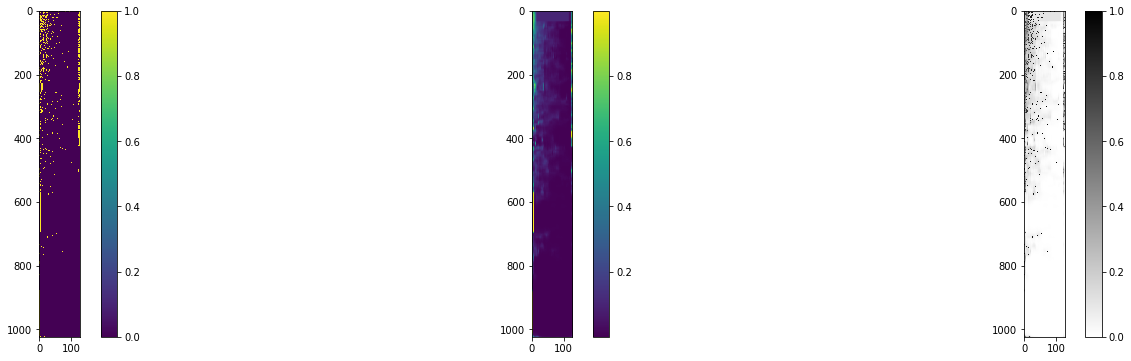

0.018121336
0.88382256


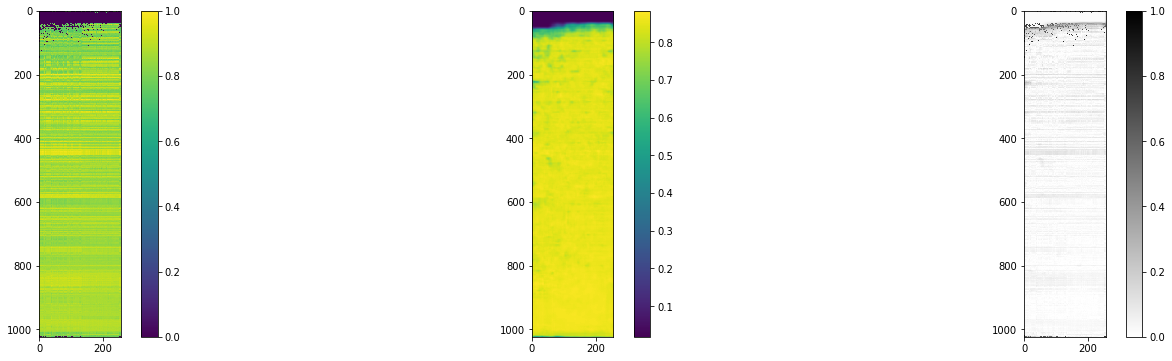

0.00020391149
0.35563266


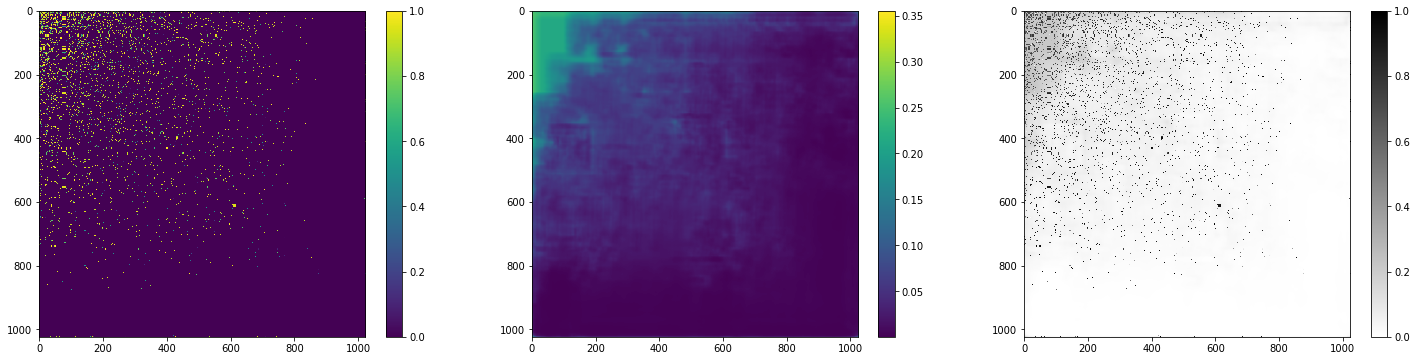

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/middle_stage_of_learning_model/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment_iteration_1_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


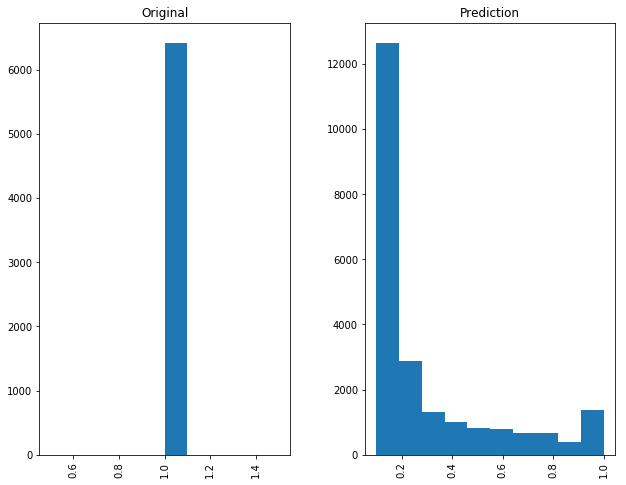

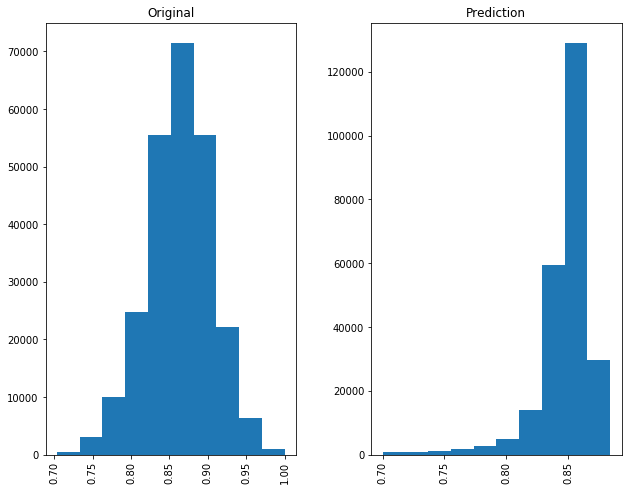

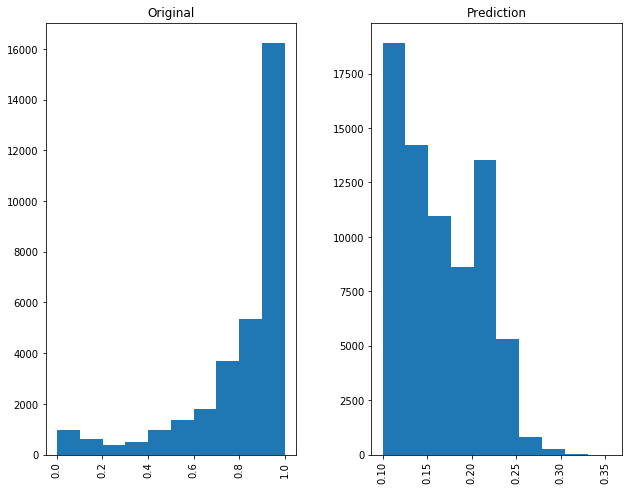

In [8]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'iteration_1_histogram_distribution_' + str(i))
    

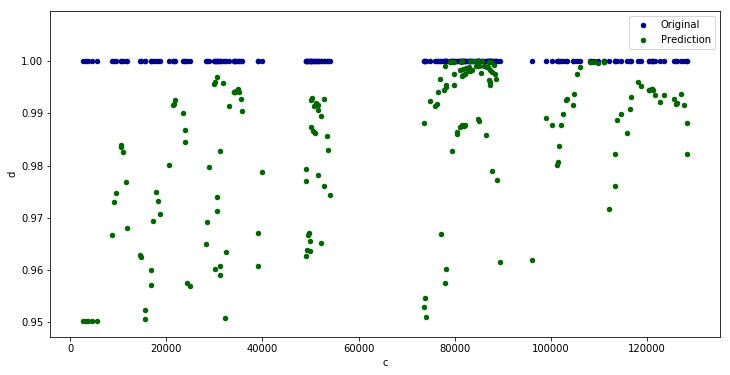

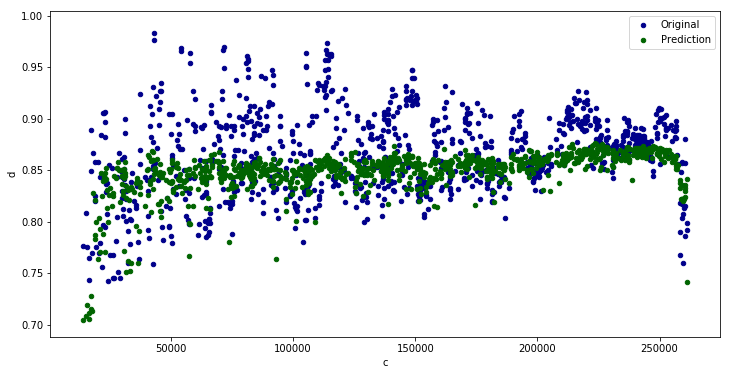

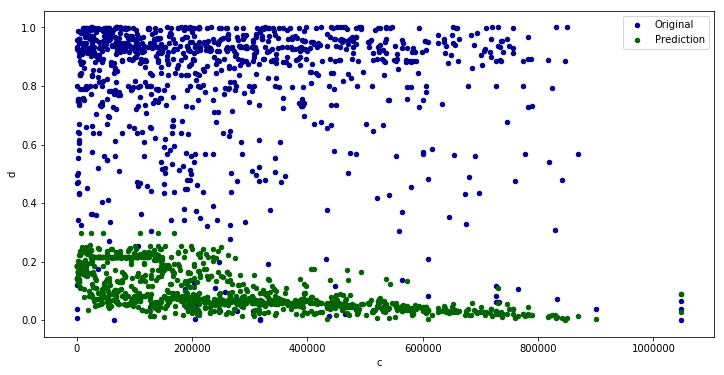

In [9]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'iteration_1_scatter_org_vs_prediction_' + str(i) + '.png')

In [21]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment) + '_2')
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		2.01213% 	6.90559% 	0.04888		0.02657		0.0		1.0	
(1024,256) 	95.4% 		0.53971% 	6.52036% 	0.82382		0.82699		0.00114		0.97369	
(1024,1024) 	3.04% 		1.90964% 	2.23528% 	0.02452		0.00268		0.0		0.32744	


In [22]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.68591 1.00000 0.31409 	(213910, 0.9037879560274013) 0.89443 0.90379 0.00935 	(688427, 0.938751472320377) 0.01347 0.93875 0.92528 	
(32635, 1.0) 0.99920 1.00000 0.00080 	(212974, 0.8941978001127759) 0.89159 0.89420 0.00261 	(4240, 0.9623085983510011) 0.26536 0.96231 0.69695 	
(2436, 1.0) 0.77037 1.00000 0.22963 	(44828, 0.8401417658060423) 0.87187 0.84014 0.03172 	(694929, 0.9799764428739693) 0.01048 0.97998 0.96950 	
(55808, 1.0) 0.63681 1.00000 0.36319 	(232148, 0.8783613613364569) 0.88209 0.87836 0.00373 	(600540, 0.5747938751472321) 0.01803 0.57479 0.55676 	
(44159, 1.0) 0.27277 1.00000 0.72723 	(106790, 0.8420843224691953) 0.85638 0.84208 0.01429 	(226406, 0.8680800942285042) 0.08291 0.86808 0.78517 	
(25344, 1.0) 0.84945 1.00000 0.15055 	(155900, 0.8219974944514251) 0.86203 0.82200 0.04004 	(122896, 0.99528857

(46219, 1.0) 0.50971 1.00000 0.49029 	(62612, 0.8908013524590833) 0.86894 0.89080 0.02186 	(146651, 0.9128386336866903) 0.04781 0.91284 0.86503 	
(58659, 1.0) 0.01761 1.00000 0.98239 	(118434, 0.9174479285497729) 0.87094 0.91745 0.04651 	(272646, 0.8138987043580682) 0.04715 0.81390 0.76675 	
(11156, 1.0) 0.14279 1.00000 0.85721 	(89238, 0.8931446765002358) 0.88683 0.89314 0.00631 	(483510, 0.9681978798586572) 0.02117 0.96820 0.94703 	
(8712, 1.0) 0.37874 1.00000 0.62126 	(222790, 0.8651861688749861) 0.90095 0.86519 0.03576 	(207996, 0.9316843345111897) 0.09560 0.93168 0.83609 	
(5655, 1.0) 0.16042 1.00000 0.83958 	(123902, 0.8427216030549833) 0.89581 0.84272 0.05309 	(465356, 1.0) 0.03195 1.00000 0.96805 	
(12302, 1.0) 0.59213 1.00000 0.40787 	(138808, 0.8876924220785591) 0.87753 0.88769 0.01016 	(101397, 0.8162544169611308) 0.22488 0.81625 0.59137 	
(24228, 1.0) 0.06376 1.00000 0.93624 	(56719, 0.8987392914948396) 0.85628 0.89874 0.04246 	(387327, 0.872791519434629) 0.03906 0.87279 0.

(11903, 1.0) 0.37943 1.00000 0.62057 	(184233, 0.8349205207692031) 0.86922 0.83492 0.03430 	(1158, 0.009422850412249812) 0.18601 0.00942 0.17658 	
(80386, 1.0) 0.99995 1.00000 0.00005 	(81549, 0.9581239256984455) 0.91905 0.95812 0.03907 	(340263, 0.9988221436984688) 0.05951 0.99882 0.93931 	
(3839, 1.0) 0.81510 1.00000 0.18490 	(55978, 0.8054739150457626) 0.86761 0.80547 0.06213 	(727709, 0.7997644287396938) 0.00903 0.79976 0.79074 	
(15116, 1.0) 0.33443 1.00000 0.66557 	(24623, 0.855467495134205) 0.75026 0.85547 0.10521 	(15481, 0.9952885747938752) 0.20273 0.99529 0.79256 	
(20254, 1.0) 0.12597 1.00000 0.87403 	(123773, 0.8448526991305813) 0.88275 0.84485 0.03790 	(196964, 0.9505300353356891) 0.04102 0.95053 0.90951 	
(18046, 1.0) 0.99668 1.00000 0.00332 	(88910, 0.9025126822120522) 0.87859 0.90251 0.02393 	(414924, 0.8457008244994111) 0.04282 0.84570 0.80288 	
(33283, 1.0) 0.95652 1.00000 0.04348 	(48003, 0.815085237445458) 0.85259 0.81509 0.03750 	(466988, 0.9281507656065962) 0.0473

(63502, 1.0) 0.18881 1.00000 0.81119 	(57553, 0.827466792972514) 0.87486 0.82747 0.04739 	(370797, 0.9328621908127209) 0.03550 0.93286 0.89737 	
(73860, 1.0) 0.96663 1.00000 0.03337 	(211606, 0.8995765536726622) 0.89171 0.89958 0.00786 	(144394, 0.7597173144876326) 0.25392 0.75972 0.50580 	
(14872, 1.0) 0.09574 1.00000 0.90426 	(163478, 0.8919840264470872) 0.89451 0.89198 0.00252 	(114856, 0.8869257950530036) 0.11612 0.88693 0.77080 	
(27541, 1.0) 0.32870 1.00000 0.67130 	(139799, 0.8526979629676908) 0.88595 0.85270 0.03325 	(195104, 0.8680800942285042) 0.03151 0.86808 0.83657 	
(35200, 1.0) 0.99950 1.00000 0.00050 	(153679, 0.807333007419831) 0.85203 0.80733 0.04469 	(315870, 0.7361601884570083) 0.04225 0.73616 0.69391 	
(49664, 1.0) 0.48352 1.00000 0.51648 	(230895, 0.8601467668232451) 0.88285 0.86015 0.02270 	(422996, 0.6784452296819788) 0.03871 0.67845 0.63973 	
(517, 1.0) 0.51412 1.00000 0.48588 	(36398, 0.7807680430257928) 0.85335 0.78077 0.07258 	(308736, 0.9316843345111897) 0.0

(40094, 1.0) 0.16355 1.00000 0.83645 	(210625, 0.8863205916304487) 0.88432 0.88632 0.00200 	(210966, 0.9988221436984688) 0.15609 0.99882 0.84273 	
(62263, 1.0) 0.02565 1.00000 0.97435 	(56059, 0.8306070617555773) 0.86013 0.83061 0.02952 	(187551, 0.10836277974087162) 0.08715 0.10836 0.02121 	
(40960, 1.0) 0.62741 1.00000 0.37259 	(198595, 0.8421631102014289) 0.87885 0.84216 0.03669 	(277787, 0.47703180212014135) 0.04505 0.47703 0.43199 	
(29979, 1.0) 0.99784 1.00000 0.00216 	(57385, 0.8511815990766316) 0.86559 0.85118 0.01441 	(101428, 0.9363957597173145) 0.20299 0.93640 0.73341 	
(18454, 1.0) 0.70142 1.00000 0.29858 	(239830, 0.8749141591041644) 0.88789 0.87491 0.01298 	(11525, 0.9375736160188458) 0.16986 0.93757 0.76772 	
(3714, 1.0) 0.49669 1.00000 0.50331 	(171167, 0.9104064461033874) 0.88018 0.91041 0.03023 	(104745, 0.9104829210836279) 0.07675 0.91048 0.83373 	
(2685, 1.0) 0.68733 1.00000 0.31267 	(173131, 0.8456254092258608) 0.87155 0.84563 0.02593 	(484516, 0.9988221436984688) 

(4751, 1.0) 0.32071 1.00000 0.67929 	(30865, 0.850848015687818) 0.88085 0.85085 0.03000 	(82035, 0.9199057714958776) 0.12687 0.91991 0.79304 	
(89728, 1.0) 0.25772 1.00000 0.74228 	(196432, 0.8477723666994413) 0.85811 0.84777 0.01034 	(16681, 0.9246171967020024) 0.13803 0.92462 0.78659 	
(4738, 1.0) 0.23921 1.00000 0.76079 	(162062, 0.9323094589311655) 0.87732 0.93231 0.05499 	(167936, 0.9281507656065962) 0.32114 0.92815 0.60701 	
(39316, 1.0) 0.46260 1.00000 0.53740 	(254018, 0.8627213398826145) 0.89165 0.86272 0.02893 	(145511, 0.8657243816254419) 0.14288 0.86572 0.72284 	
(126977, 1.0) 1.00000 1.00000 0.00000 	(144408, 0.8562474300935635) 0.87619 0.85625 0.01994 	(104535, 0.96113074204947) 0.20299 0.96113 0.75815 	
(53381, 1.0) 0.92104 1.00000 0.07896 	(34221, 0.847709794418642) 0.87026 0.84771 0.02255 	(310304, 0.9705535924617197) 0.11995 0.97055 0.85060 	
(11519, 1.0) 0.66561 1.00000 0.33439 	(13034, 0.8413900033969399) 0.80118 0.84139 0.04021 	(67857, 0.8150765606595995) 0.07498 

(98307, 1.0) 0.58338 1.00000 0.41662 	(98936, 0.8264761295751925) 0.86956 0.82648 0.04308 	(303380, 0.9340400471142521) 0.03889 0.93404 0.89515 	
(30989, 1.0) 0.99747 1.00000 0.00253 	(30949, 0.8629280548822288) 0.87734 0.86293 0.01442 	(304265, 0.5111896348645465) 0.04589 0.51119 0.46530 	
(129921, 1.0) 0.99998 1.00000 0.00002 	(42822, 0.7588843823223201) 0.87150 0.75888 0.11261 	(84196, 0.92226148409894) 0.09745 0.92226 0.82482 	
(12671, 1.0) 0.82350 1.00000 0.17650 	(261373, 0.7917948910537543) 0.76853 0.79179 0.02327 	(70842, 0.9458186101295644) 0.09022 0.94582 0.85560 	
(70918, 1.0) 0.04574 1.00000 0.95426 	(201581, 0.8300839268039246) 0.88204 0.83008 0.05195 	(4241, 0.9623085983510011) 0.26563 0.96231 0.69668 	
(20493, 1.0) 0.23339 1.00000 0.76661 	(185007, 0.8389086283169533) 0.86684 0.83891 0.02793 	(383200, 0.8939929328621907) 0.05088 0.89399 0.84311 	
(4615, 1.0) 0.36393 1.00000 0.63607 	(105089, 0.8015273975526116) 0.87973 0.80153 0.07820 	(344194, 0.9740871613663132) 0.0615

(38141, 1.0) 0.73476 1.00000 0.26524 	(230818, 0.8733334325430157) 0.88109 0.87333 0.00776 	(4289, 0.7432273262661956) 0.26015 0.74323 0.48308 	
(13052, 1.0) 0.59328 1.00000 0.40672 	(240867, 0.8819198437143556) 0.88892 0.88192 0.00700 	(649311, 0.9045936395759718) 0.01504 0.90459 0.88955 	
(3967, 1.0) 0.81510 1.00000 0.18490 	(138673, 0.9047815475844958) 0.88830 0.90478 0.01649 	(348437, 0.9634864546525324) 0.03973 0.96349 0.92376 	
(45715, 1.0) 0.45756 1.00000 0.54244 	(243099, 0.8905052331924809) 0.88550 0.89051 0.00501 	(210185, 0.9988221436984688) 0.04314 0.99882 0.95568 	
(43049, 1.0) 0.09825 1.00000 0.90175 	(258911, 0.8487409920465296) 0.81496 0.84874 0.03378 	(528920, 0.8928150765606597) 0.02799 0.89282 0.86482 	
(10254, 1.0) 0.31882 1.00000 0.68118 	(225285, 0.8762522285245682) 0.89473 0.87625 0.01848 	(105734, 0.25206124852767964) 0.06659 0.25206 0.18548 	
(56247, 1.0) 0.51180 1.00000 0.48820 	(249990, 0.8979358190073011) 0.88359 0.89794 0.01435 	(12343, 0.9269729093050648) 

(21508, 1.0) 0.18437 1.00000 0.81563 	(132202, 0.8801512578739892) 0.88268 0.88015 0.00252 	(440531, 0.8433451118963486) 0.03020 0.84335 0.81314 	
(13308, 1.0) 0.19034 1.00000 0.80966 	(117615, 0.9004110904157334) 0.89845 0.90041 0.00196 	(526371, 0.9976442873969376) 0.03591 0.99764 0.96174 	
(125569, 1.0) 1.00000 1.00000 0.00000 	(13073, 0.8090882139718364) 0.33787 0.80909 0.47122 	(28724, 0.6383981154299176) 0.21001 0.63840 0.42839 	
(69138, 1.0) 0.21214 1.00000 0.78786 	(173327, 0.8816254587155269) 0.87903 0.88163 0.00259 	(470176, 0.5017667844522969) 0.03170 0.50177 0.47007 	
(8854, 1.0) 0.23816 1.00000 0.76184 	(91751, 0.8285444614860222) 0.88646 0.82854 0.05791 	(126327, 0.6607773851590106) 0.04359 0.66078 0.61719 	
(64047, 1.0) 0.87795 1.00000 0.12205 	(18113, 0.8667973805014995) 0.83173 0.86680 0.03507 	(221840, 0.568904593639576) 0.02269 0.56890 0.54621 	
(50429, 1.0) 0.99725 1.00000 0.00275 	(15641, 0.7642865099690954) 0.51856 0.76429 0.24573 	(66671, 0.5606595995288576) 0.12

(68229, 1.0) 0.60723 1.00000 0.39277 	(228306, 0.8749296341047026) 0.89333 0.87493 0.01840 	(113848, 0.917550058892815) 0.11206 0.91755 0.80549 	
(101248, 1.0) 0.33088 1.00000 0.66912 	(83869, 0.8613132150123359) 0.88117 0.86131 0.01986 	(174335, 0.082449941107185) 0.08072 0.08245 0.00173 	
(30849, 1.0) 0.98016 1.00000 0.01984 	(78953, 0.8496581148669601) 0.87915 0.84966 0.02949 	(305867, 0.9316843345111897) 0.00748 0.93168 0.92421 	
(20628, 1.0) 0.22990 1.00000 0.77010 	(127105, 0.8540905750718667) 0.86380 0.85409 0.00971 	(115737, 0.9658421672555949) 0.21449 0.96584 0.75135 	
(3328, 1.0) 0.77450 1.00000 0.22550 	(236741, 0.8869982168472444) 0.89052 0.88700 0.00352 	(4216, 0.9163722025912839) 0.26777 0.91637 0.64860 	
(113409, 1.0) 1.00000 1.00000 0.00000 	(192311, 0.8926247991216609) 0.91973 0.89262 0.02711 	(345325, 0.8916372202591284) 0.04710 0.89164 0.84454 	
(95493, 1.0) 0.38815 1.00000 0.61185 	(106074, 0.8490803274896342) 0.86772 0.84908 0.01863 	(288840, 0.9599528857479388) 0.

(40330, 1.0) 0.29937 1.00000 0.70063 	(110454, 0.9323364853437688) 0.90952 0.93234 0.02282 	(104532, 0.6407538280329801) 0.20299 0.64075 0.43777 	
(128257, 1.0) 1.00000 1.00000 0.00000 	(198137, 0.8582971444399814) 0.88090 0.85830 0.02261 	(677924, 0.7997644287396938) 0.02630 0.79976 0.77347 	
(88579, 1.0) 0.99349 1.00000 0.00651 	(33836, 0.8387112416589894) 0.82080 0.83871 0.01791 	(268881, 0.7161366313309776) 0.00583 0.71614 0.71030 	
(53641, 1.0) 0.96643 1.00000 0.03357 	(197301, 0.8542434945124281) 0.87967 0.85424 0.02543 	(690667, 0.5594817432273262) 0.01658 0.55948 0.54290 	
(77696, 1.0) 0.99835 1.00000 0.00165 	(186433, 0.824231854309833) 0.86840 0.82423 0.04417 	(417976, 0.8386336866902238) 0.03939 0.83863 0.79925 	
(64384, 1.0) 0.85056 1.00000 0.14944 	(129759, 0.8238710292745943) 0.88720 0.82387 0.06333 	(85020, 0.9729093050647822) 0.20824 0.97291 0.76467 	
(9229, 1.0) 0.54155 1.00000 0.45845 	(64122, 0.7937210765695902) 0.85664 0.79372 0.06292 	(202845, 0.12720848056537107) 

(6523, 1.0) 0.62126 1.00000 0.37874 	(156829, 0.8588910442524044) 0.86712 0.85889 0.00823 	(495824, 0.8492343934040048) 0.02514 0.84923 0.82409 	
(79744, 1.0) 0.99993 1.00000 0.00007 	(170209, 0.9003928379679494) 0.89209 0.90039 0.00830 	(27773, 0.9599528857479388) 0.15972 0.95995 0.80023 	
(75012, 1.0) 0.74545 1.00000 0.25455 	(163316, 0.8481707304798932) 0.87228 0.84817 0.02411 	(335913, 0.37691401648998824) 0.05767 0.37691 0.31924 	
(60971, 1.0) 0.22220 1.00000 0.77780 	(176568, 0.8492619693541988) 0.88694 0.84926 0.03768 	(522274, 0.9976442873969376) 0.04412 0.99764 0.95353 	
(24965, 1.0) 0.36023 1.00000 0.63977 	(42692, 0.853909995731215) 0.89772 0.85391 0.04381 	(3082, 0.6431095406360424) 0.27367 0.64311 0.36944 	
(99203, 1.0) 0.61707 1.00000 0.38293 	(216042, 0.8997687058735201) 0.89248 0.89977 0.00729 	(282645, 0.9352179034157833) 0.09088 0.93522 0.84434 	
(12168, 1.0) 0.54659 1.00000 0.45341 	(154567, 0.8262420522934192) 0.83723 0.82624 0.01099 	(583336, 0.8857479387514724) 0.

(89472, 1.0) 0.30735 1.00000 0.69265 	(191661, 0.8793345304379501) 0.87552 0.87933 0.00381 	(204287, 0.9340400471142521) 0.04310 0.93404 0.89094 	
(29077, 1.0) 0.32875 1.00000 0.67125 	(10901, 0.7593222261719577) 0.49053 0.75932 0.26879 	(57020, 0.9599528857479388) 0.01690 0.95995 0.94305 	
(102144, 1.0) 0.26707 1.00000 0.73293 	(30719, 0.8412716763964043) 0.81628 0.84127 0.02499 	(675172, 0.3286219081272086) 0.01498 0.32862 0.31364 	
(12541, 1.0) 0.35941 1.00000 0.64059 	(176424, 0.8385050861486328) 0.88707 0.83851 0.04857 	(17475, 0.9976442873969376) 0.26762 0.99764 0.73003 	
(74117, 1.0) 0.08192 1.00000 0.91808 	(178017, 0.9034995650409264) 0.87643 0.90350 0.02707 	(449575, 0.7361601884570083) 0.05528 0.73616 0.68088 	
(84992, 1.0) 0.99999 1.00000 0.00001 	(120778, 0.8490222885068348) 0.88015 0.84902 0.03113 	(774707, 0.8857479387514724) 0.00345 0.88575 0.88230 	
(33808, 1.0) 0.40517 1.00000 0.59483 	(15309, 0.8080613765671922) 0.79661 0.80806 0.01145 	(209007, 0.054181389870435887)

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


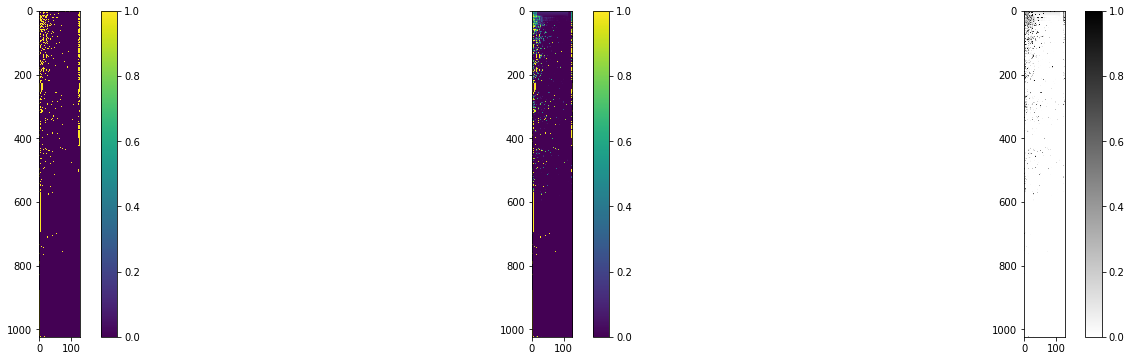

1.984671e-06
0.9751796


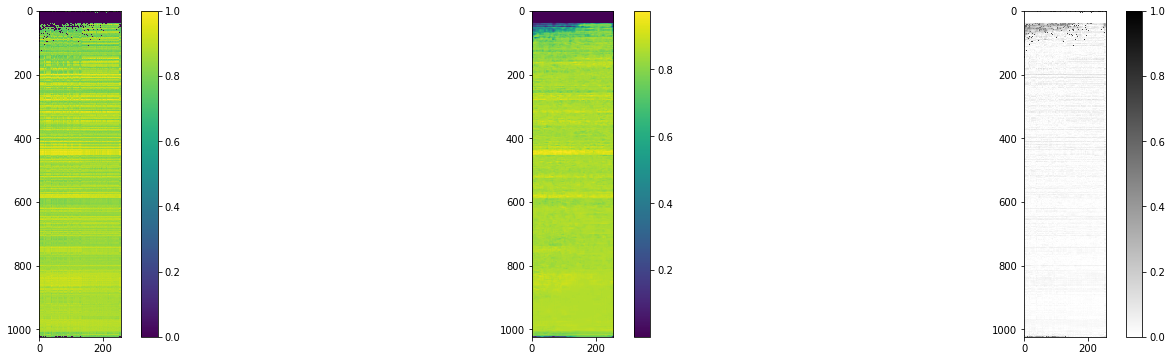

1.5611286e-09
0.44822773


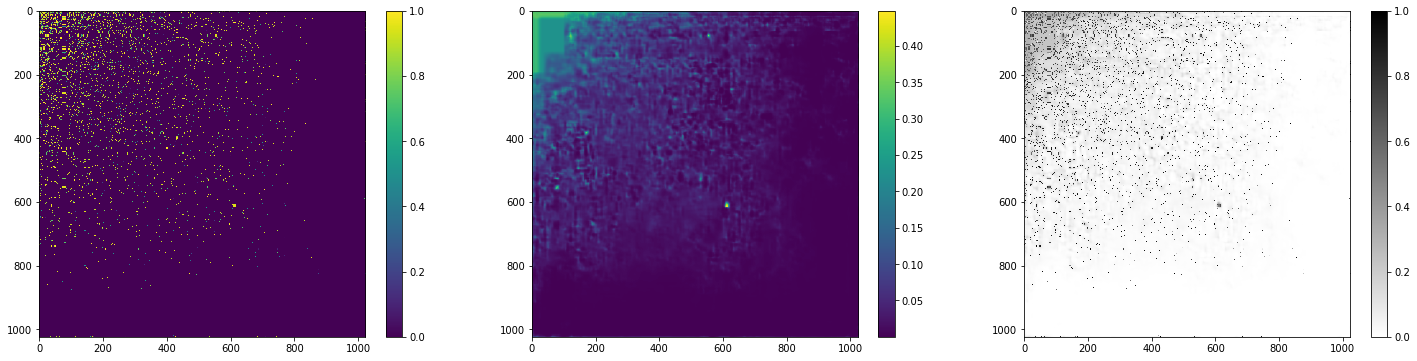

In [17]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/middle_stage_of_learning_model/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment_iteration_2_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


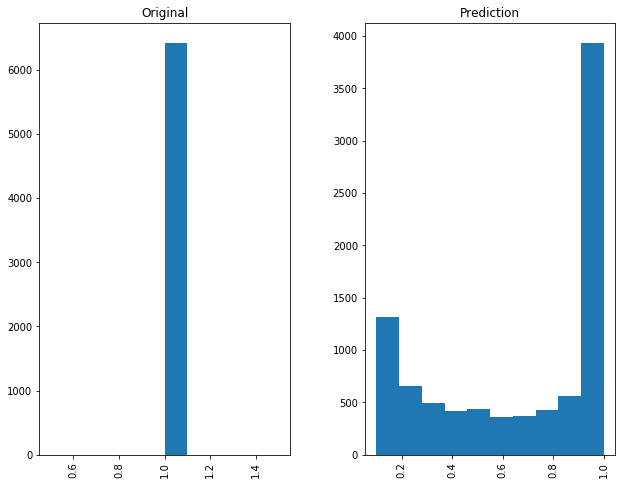

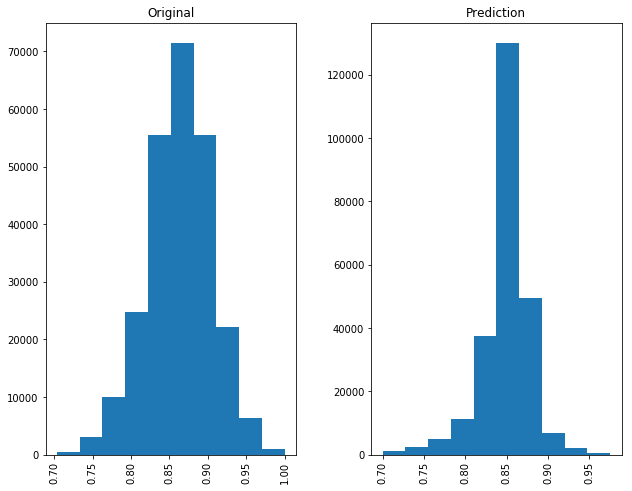

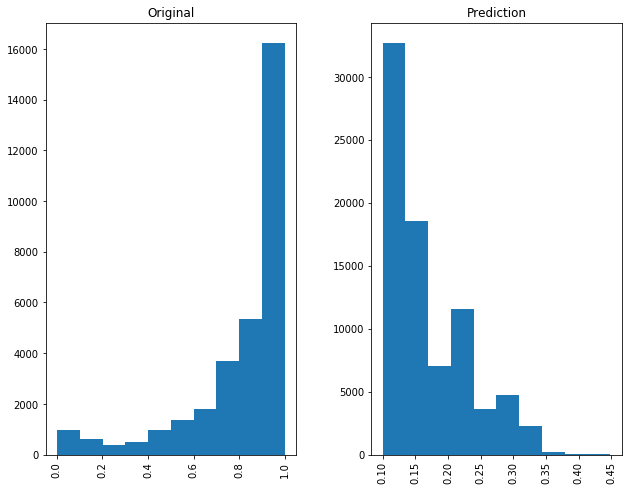

In [18]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'iteration_2_histogram_distribution_' + str(i))
    

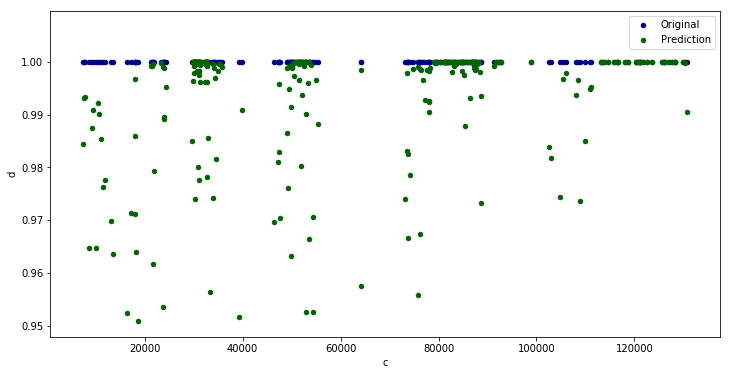

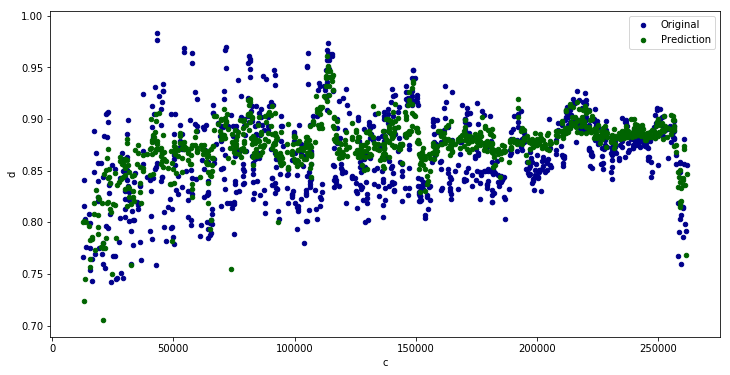

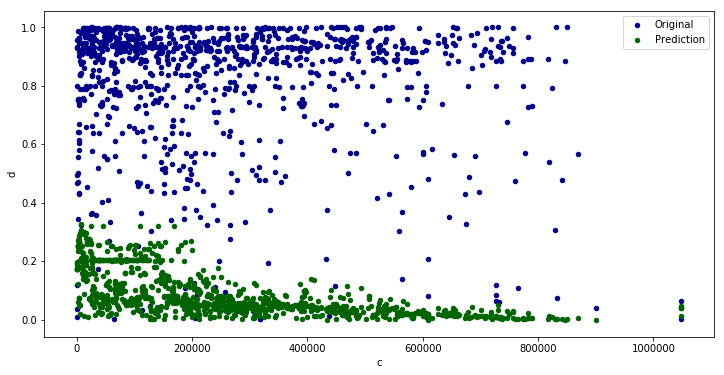

In [23]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'iteration_2_scatter_org_vs_prediction_' + str(i) + '.png')

In [24]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment) + '_3')
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)
Data		Density		Predict		BaseLine	AVG Mean	Predict (mean)	Predict (min)	Predict (max)	
(1024,128) 	4.89% 		0.79068% 	8.34825% 	0.04888		0.04011		0.0		1.0	
(1024,256) 	95.4% 		0.50732% 	6.46112% 	0.82382		0.8045		0.0		0.97518	
(1024,1024) 	3.04% 		1.90246% 	2.32581% 	0.02452		0.00356		0.0		0.44823	


In [25]:
model.predict_hidden_cells()


Predict Original Diff 		Predict Original Diff 		Predict Original Diff
---------------------------------------------------------------------------------------
(25214, 1.0) 0.99992 1.00000 0.00008 	(213910, 0.9037879560274013) 0.88356 0.90379 0.02023 	(688427, 0.938751472320377) 0.02488 0.93875 0.91388 	
(32635, 1.0) 1.00000 1.00000 0.00000 	(212974, 0.8941978001127759) 0.86680 0.89420 0.02740 	(4240, 0.9623085983510011) 0.30329 0.96231 0.65902 	
(2436, 1.0) 0.94568 1.00000 0.05432 	(44828, 0.8401417658060423) 0.85330 0.84014 0.01316 	(694929, 0.9799764428739693) 0.03225 0.97998 0.94773 	
(55808, 1.0) 0.77946 1.00000 0.22054 	(232148, 0.8783613613364569) 0.85764 0.87836 0.02072 	(600540, 0.5747938751472321) 0.02899 0.57479 0.54580 	
(44159, 1.0) 0.54601 1.00000 0.45399 	(106790, 0.8420843224691953) 0.84699 0.84208 0.00491 	(226406, 0.8680800942285042) 0.08481 0.86808 0.78327 	
(25344, 1.0) 1.00000 1.00000 0.00000 	(155900, 0.8219974944514251) 0.82155 0.82200 0.00045 	(122896, 0.99528857

(25105, 1.0) 0.99412 1.00000 0.00588 	(83215, 0.8801234976685764) 0.86774 0.88012 0.01238 	(609364, 0.9493521790341579) 0.02627 0.94935 0.92308 	
(20779, 1.0) 0.99997 1.00000 0.00003 	(22918, 0.9065176667814063) 0.82686 0.90652 0.07966 	(660654, 0.8869257950530036) 0.02841 0.88693 0.85852 	
(2580, 1.0) 0.68372 1.00000 0.31628 	(81452, 0.9560840745164847) 0.89571 0.95608 0.06037 	(253066, 0.9646643109540636) 0.08516 0.96466 0.87951 	
(46219, 1.0) 0.89150 1.00000 0.10850 	(62612, 0.8908013524590833) 0.84956 0.89080 0.04124 	(146651, 0.9128386336866903) 0.07406 0.91284 0.83878 	
(58659, 1.0) 0.13916 1.00000 0.86084 	(118434, 0.9174479285497729) 0.84450 0.91745 0.07294 	(272646, 0.8138987043580682) 0.06508 0.81390 0.74881 	
(11156, 1.0) 0.41399 1.00000 0.58601 	(89238, 0.8931446765002358) 0.87505 0.89314 0.01810 	(483510, 0.9681978798586572) 0.07961 0.96820 0.88859 	
(8712, 1.0) 0.87252 1.00000 0.12748 	(222790, 0.8651861688749861) 0.86989 0.86519 0.00471 	(207996, 0.9316843345111897) 0.11

(59432, 1.0) 0.66202 1.00000 0.33798 	(161839, 0.910907470627851) 0.86315 0.91091 0.04776 	(717879, 0.9599528857479388) 0.05821 0.95995 0.90174 	
(2438, 1.0) 0.80573 1.00000 0.19427 	(210231, 0.8654352000718556) 0.85614 0.86544 0.00930 	(247088, 0.9988221436984688) 0.06553 0.99882 0.93329 	
(23421, 1.0) 0.99984 1.00000 0.00016 	(102663, 0.8231137999290139) 0.85268 0.82311 0.02956 	(5113, 0.9081272084805654) 0.05459 0.90813 0.85354 	
(66812, 1.0) 0.28315 1.00000 0.71685 	(176870, 0.8457460818770137) 0.85561 0.84575 0.00986 	(474343, 0.9599528857479388) 0.03358 0.95995 0.92638 	
(68070, 1.0) 0.92120 1.00000 0.07880 	(13579, 0.7717501726755115) 0.32545 0.77175 0.44630 	(190691, 0.7856301531213193) 0.10951 0.78563 0.67612 	
(672, 1.0) 0.11236 1.00000 0.88764 	(203463, 0.8486464072366304) 0.85036 0.84865 0.00172 	(397756, 0.8928150765606597) 0.03694 0.89282 0.85588 	
(11903, 1.0) 0.83471 1.00000 0.16529 	(184233, 0.8349205207692031) 0.84765 0.83492 0.01273 	(1158, 0.009422850412249812) 0.23

(31259, 1.0) 1.00000 1.00000 0.00000 	(210727, 0.8573664020360111) 0.85656 0.85737 0.00081 	(12957, 0.8621908127208481) 0.06317 0.86219 0.79902 	
(46331, 1.0) 0.98800 1.00000 0.01200 	(168194, 0.8780051560399823) 0.84550 0.87801 0.03250 	(702686, 0.8704358068315666) 0.02868 0.87044 0.84176 	
(32382, 1.0) 1.00000 1.00000 0.00000 	(257284, 0.8650395986924343) 0.83303 0.86504 0.03201 	(97323, 0.9316843345111897) 0.22925 0.93168 0.70243 	
(24345, 1.0) 0.94518 1.00000 0.05482 	(59803, 0.8881339056185946) 0.84757 0.88813 0.04056 	(363842, 0.9929328621908128) 0.04755 0.99293 0.94538 	
(6403, 1.0) 0.90183 1.00000 0.09817 	(169963, 0.842073717131995) 0.86681 0.84207 0.02474 	(92585, 0.9693757361601885) 0.08484 0.96938 0.88453 	
(5276, 1.0) 0.38279 1.00000 0.61721 	(84172, 0.886045453659032) 0.85782 0.88605 0.02822 	(61792, 0.9363957597173145) 0.07518 0.93640 0.86121 	
(52735, 1.0) 1.00000 1.00000 0.00000 	(152991, 0.8324476183571349) 0.83912 0.83245 0.00668 	(88500, 0.9634864546525324) 0.15022 

(11415, 1.0) 0.77030 1.00000 0.22970 	(57542, 0.8429582260891303) 0.84274 0.84296 0.00022 	(305267, 0.030624263839811604) 0.07557 0.03062 0.04495 	
(5013, 1.0) 0.24211 1.00000 0.75789 	(179534, 0.8364089316276746) 0.86230 0.83641 0.02589 	(140444, 0.9316843345111897) 0.09298 0.93168 0.83870 	
(35712, 1.0) 1.00000 1.00000 0.00000 	(96863, 0.8329189540430425) 0.84186 0.83292 0.00894 	(199092, 0.9846878680800943) 0.06206 0.98469 0.92263 	
(26752, 1.0) 0.99809 1.00000 0.00191 	(186891, 0.8033480663905581) 0.82247 0.80335 0.01912 	(190911, 0.480565371024735) 0.06702 0.48057 0.41355 	
(4237, 1.0) 0.08994 1.00000 0.91006 	(179828, 0.8500878475695915) 0.85034 0.85009 0.00025 	(125968, 0.9952885747938752) 0.29871 0.99529 0.69658 	
(18446, 1.0) 0.99951 1.00000 0.00049 	(210532, 0.8946273489263579) 0.87393 0.89463 0.02070 	(470199, 0.8409893992932863) 0.07392 0.84099 0.76707 	
(25215, 1.0) 0.99572 1.00000 0.00428 	(258372, 0.818371230272342) 0.80887 0.81837 0.00950 	(153781, 0.6195524146054182) 0

(16910, 1.0) 0.57534 1.00000 0.42466 	(83932, 0.884518567590305) 0.83945 0.88452 0.04507 	(389358, 0.7302709069493521) 0.09029 0.73027 0.63998 	
(3453, 1.0) 0.75791 1.00000 0.24209 	(189161, 0.8675394071099043) 0.84999 0.86754 0.01755 	(51561, 0.9952885747938752) 0.05905 0.99529 0.93624 	
(105729, 1.0) 0.98635 1.00000 0.01365 	(15766, 0.7754668020513852) 0.69094 0.77547 0.08453 	(425526, 0.8869257950530036) 0.00680 0.88693 0.88013 	
(21381, 1.0) 0.98571 1.00000 0.01429 	(231372, 0.868781537296818) 0.85406 0.86878 0.01472 	(235530, 0.9623085983510011) 0.17132 0.96231 0.79099 	
(16674, 1.0) 0.90934 1.00000 0.09066 	(217542, 0.8926509387380589) 0.88100 0.89265 0.01165 	(64552, 0.8798586572438163) 0.22925 0.87986 0.65061 	
(34560, 1.0) 0.99869 1.00000 0.00131 	(220397, 0.8989954763130382) 0.86895 0.89900 0.03005 	(357463, 0.9988221436984688) 0.08654 0.99882 0.91228 	
(118145, 1.0) 1.00000 1.00000 0.00000 	(140142, 0.8541654858131725) 0.85280 0.85417 0.00137 	(141316, 0.9623085983510011) 0.

(17934, 1.0) 0.99921 1.00000 0.00079 	(260400, 0.8151508578368154) 0.78921 0.81515 0.02594 	(120476, 0.8869257950530036) 0.03562 0.88693 0.85130 	
(19475, 1.0) 0.90033 1.00000 0.09967 	(195711, 0.8518479630503047) 0.84816 0.85185 0.00369 	(5786, 0.8398115429917551) 0.05505 0.83981 0.78476 	
(69413, 1.0) 0.94326 1.00000 0.05674 	(94565, 0.9028472883172113) 0.85467 0.90285 0.04818 	(367847, 0.8716136631330978) 0.05282 0.87161 0.81880 	
(17919, 1.0) 1.00000 1.00000 0.00000 	(250174, 0.855742306732544) 0.86934 0.85574 0.01360 	(633163, 0.7385159010600707) 0.03852 0.73852 0.70000 	
(49916, 1.0) 1.00000 1.00000 0.00000 	(106722, 0.869132617409218) 0.81134 0.86913 0.05779 	(506011, 0.9340400471142521) 0.10276 0.93404 0.83128 	
(49066, 1.0) 0.99930 1.00000 0.00070 	(146392, 0.9133931105713333) 0.88948 0.91339 0.02391 	(164138, 0.9988221436984688) 0.12525 0.99882 0.87358 	
(50177, 1.0) 1.00000 1.00000 0.00000 	(33000, 0.8112037328508214) 0.80629 0.81120 0.00491 	(77936, 0.8869257950530036) 0.15

(35456, 1.0) 1.00000 1.00000 0.00000 	(194852, 0.8777957179090337) 0.86089 0.87780 0.01690 	(100702, 0.8998822143698468) 0.08291 0.89988 0.81697 	
(39554, 1.0) 0.98363 1.00000 0.01637 	(250996, 0.900351673754996) 0.87166 0.90035 0.02869 	(166369, 0.6643109540636043) 0.05852 0.66431 0.60580 	
(5899, 1.0) 0.27616 1.00000 0.72384 	(16295, 0.7647971904350622) 0.68710 0.76480 0.07770 	(55044, 0.41107184923439344) 0.02550 0.41107 0.38557 	
(42117, 1.0) 0.99771 1.00000 0.00229 	(107637, 0.8970799608454415) 0.89008 0.89708 0.00700 	(73896, 0.7797408716136632) 0.17260 0.77974 0.60714 	
(31100, 1.0) 1.00000 1.00000 0.00000 	(252123, 0.8832088031638589) 0.86612 0.88321 0.01709 	(153754, 0.5206124852767963) 0.13183 0.52061 0.38878 	
(34304, 1.0) 1.00000 1.00000 0.00000 	(164420, 0.8417064083459637) 0.82824 0.84171 0.01347 	(433456, 0.657243816254417) 0.06872 0.65724 0.58853 	
(2427, 1.0) 0.52866 1.00000 0.47134 	(146162, 0.9318169480565922) 0.87145 0.93182 0.06036 	(181593, 0.8904593639575972) 0.0

(83588, 1.0) 1.00000 1.00000 0.00000 	(141506, 0.8856886969333677) 0.85613 0.88569 0.02956 	(73227, 0.9316843345111897) 0.07153 0.93168 0.86015 	
(51853, 1.0) 0.99762 1.00000 0.00238 	(134698, 0.8260376096497122) 0.84848 0.82604 0.02244 	(533615, 0.8857479387514724) 0.06443 0.88575 0.82132 	
(5130, 1.0) 0.24378 1.00000 0.75622 	(87791, 0.8089849743083601) 0.84701 0.80898 0.03802 	(20687, 0.9646643109540636) 0.15336 0.96466 0.81130 	
(38660, 1.0) 0.37457 1.00000 0.62543 	(23989, 0.8381250170581108) 0.78794 0.83813 0.05019 	(129435, 0.7714958775029447) 0.04046 0.77150 0.73104 	
(68736, 1.0) 0.98979 1.00000 0.01021 	(18818, 0.8206210015061952) 0.75695 0.82062 0.06367 	(105505, 0.938751472320377) 0.22925 0.93875 0.70950 	
(51453, 1.0) 1.00000 1.00000 0.00000 	(91959, 0.9427901936767836) 0.86167 0.94279 0.08112 	(485949, 0.7997644287396938) 0.01778 0.79976 0.78198 	
(73220, 1.0) 1.00000 1.00000 0.00000 	(33413, 0.778189160411582) 0.77265 0.77819 0.00554 	(237823, 0.8998822143698468) 0.08790

(9230, 1.0) 0.30247 1.00000 0.69753 	(179538, 0.8328468285242104) 0.86790 0.83285 0.03506 	(327060, 0.4782096584216726) 0.04829 0.47821 0.42992 	
(1671, 1.0) 0.51657 1.00000 0.48343 	(175724, 0.8671745302365235) 0.86214 0.86717 0.00503 	(6157, 0.8869257950530036) 0.31191 0.88693 0.57502 	
(71168, 1.0) 0.81186 1.00000 0.18814 	(64325, 0.7848895001929161) 0.80053 0.78489 0.01564 	(3191, 0.6690223792697292) 0.29666 0.66902 0.37236 	
(102402, 1.0) 1.00000 1.00000 0.00000 	(57185, 0.8021564612159402) 0.85102 0.80216 0.04887 	(263184, 0.7891637220259129) 0.18634 0.78916 0.60282 	
(47617, 1.0) 0.92206 1.00000 0.07794 	(181929, 0.8470636133854084) 0.83787 0.84706 0.00920 	(65729, 0.6124852767962309) 0.11306 0.61249 0.49943 	
(2688, 1.0) 0.96257 1.00000 0.03743 	(91446, 0.9477801229620043) 0.87070 0.94778 0.07708 	(70710, 1.0) 0.22925 1.00000 0.77075 	
(56221, 1.0) 0.94146 1.00000 0.05854 	(179525, 0.8372383492381311) 0.84506 0.83724 0.00782 	(204440, 0.568904593639576) 0.03148 0.56890 0.53742 

(6018, 1.0) 0.91527 1.00000 0.08473 	(55863, 0.8220213485791736) 0.84206 0.82202 0.02004 	(55508, 0.6949352179034158) 0.09104 0.69494 0.60390 	
(52873, 1.0) 1.00000 1.00000 0.00000 	(23479, 0.8285862945917584) 0.82269 0.82859 0.00589 	(355703, 0.9316843345111897) 0.06946 0.93168 0.86223 	
(70028, 1.0) 0.98600 1.00000 0.01400 	(35607, 0.816500176695045) 0.82156 0.81650 0.00506 	(557600, 0.8586572438162545) 0.00304 0.85866 0.85562 	
(40330, 1.0) 0.80476 1.00000 0.19524 	(110454, 0.9323364853437688) 0.88229 0.93234 0.05004 	(104532, 0.6407538280329801) 0.22925 0.64075 0.41150 	
(128257, 1.0) 1.00000 1.00000 0.00000 	(198137, 0.8582971444399814) 0.84980 0.85830 0.00850 	(677924, 0.7997644287396938) 0.02541 0.79976 0.77435 	
(88579, 1.0) 1.00000 1.00000 0.00000 	(33836, 0.8387112416589894) 0.80945 0.83871 0.02926 	(268881, 0.7161366313309776) 0.01547 0.71614 0.70067 	
(53641, 1.0) 1.00000 1.00000 0.00000 	(197301, 0.8542434945124281) 0.84543 0.85424 0.00881 	(690667, 0.5594817432273262) 0.0

(6523, 1.0) 0.98697 1.00000 0.01303 	(156829, 0.8588910442524044) 0.85428 0.85889 0.00461 	(495824, 0.8492343934040048) 0.05311 0.84923 0.79612 	
(79744, 1.0) 1.00000 1.00000 0.00000 	(170209, 0.9003928379679494) 0.87401 0.90039 0.02638 	(27773, 0.9599528857479388) 0.26722 0.95995 0.69273 	
(75012, 1.0) 0.99979 1.00000 0.00021 	(163316, 0.8481707304798932) 0.85450 0.84817 0.00633 	(335913, 0.37691401648998824) 0.09305 0.37691 0.28386 	
(60971, 1.0) 0.51673 1.00000 0.48327 	(176568, 0.8492619693541988) 0.85223 0.84926 0.00297 	(522274, 0.9976442873969376) 0.06724 0.99764 0.93040 	
(24965, 1.0) 0.88414 1.00000 0.11586 	(42692, 0.853909995731215) 0.88558 0.85391 0.03167 	(3082, 0.6431095406360424) 0.31182 0.64311 0.33129 	
(99203, 1.0) 1.00000 1.00000 0.00000 	(216042, 0.8997687058735201) 0.86732 0.89977 0.03245 	(282645, 0.9352179034157833) 0.13620 0.93522 0.79901 	
(12168, 1.0) 0.98787 1.00000 0.01213 	(154567, 0.8262420522934192) 0.81994 0.82624 0.00630 	(583336, 0.8857479387514724) 0.

(14340, 1.0) 0.99721 1.00000 0.00279 	(66075, 0.7983609859410544) 0.79066 0.79836 0.00770 	(11429, 0.9964664310954064) 0.29103 0.99647 0.70544 	
(28167, 1.0) 0.96945 1.00000 0.03055 	(126925, 0.8585312715407508) 0.85125 0.85853 0.00729 	(473115, 0.5712603062426385) 0.08746 0.57126 0.48380 	
(89776, 1.0) 0.99805 1.00000 0.00195 	(148610, 0.9400099562567668) 0.90124 0.94001 0.03877 	(116841, 0.5594817432273262) 0.15198 0.55948 0.40750 	
(49322, 1.0) 0.99997 1.00000 0.00003 	(218853, 0.8883106709129801) 0.87268 0.88831 0.01563 	(390823, 0.7314487632508835) 0.03279 0.73145 0.69866 	
(31753, 1.0) 0.87027 1.00000 0.12973 	(176381, 0.8836076636835443) 0.84833 0.88361 0.03528 	(351599, 0.795053003533569) 0.08424 0.79505 0.71082 	
(89472, 1.0) 0.99578 1.00000 0.00422 	(191661, 0.8793345304379501) 0.84263 0.87933 0.03671 	(204287, 0.9340400471142521) 0.18777 0.93404 0.74627 	
(29077, 1.0) 0.97162 1.00000 0.02838 	(10901, 0.7593222261719577) 0.41684 0.75932 0.34248 	(57020, 0.9599528857479388) 0.

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


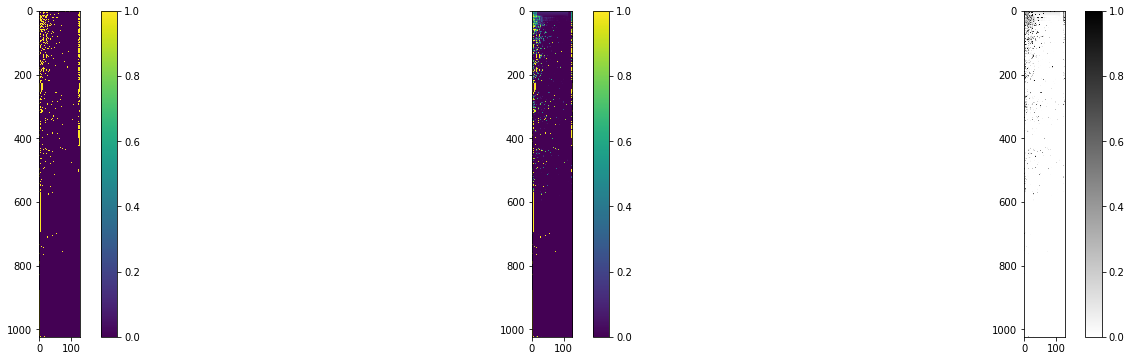

1.984671e-06
0.9751796


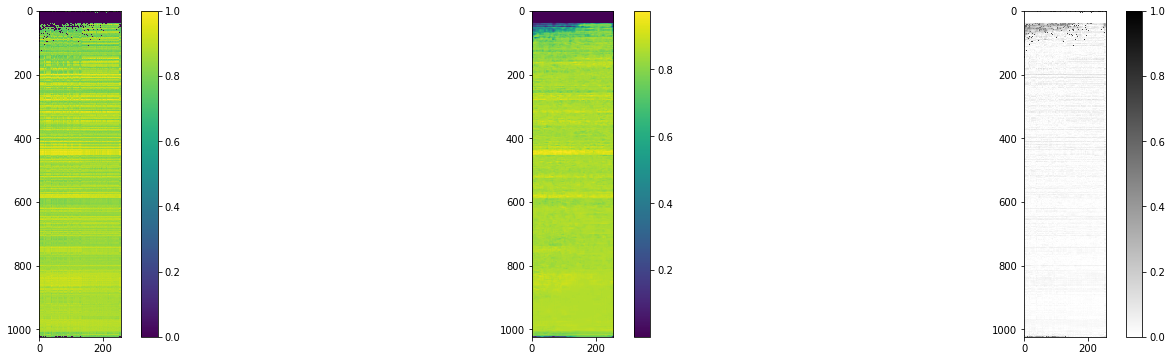

1.5611286e-09
0.44822773


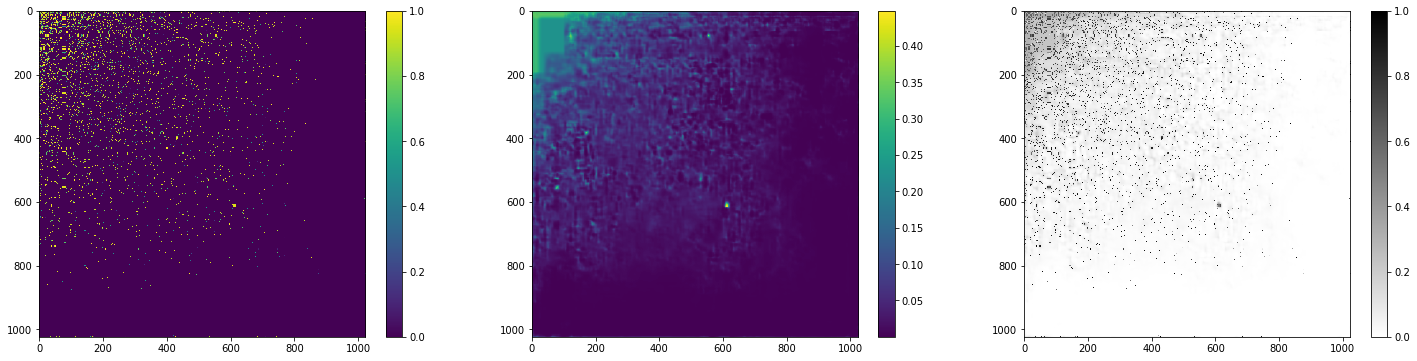

In [26]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/middle_stage_of_learning_model/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment_iteration_3_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


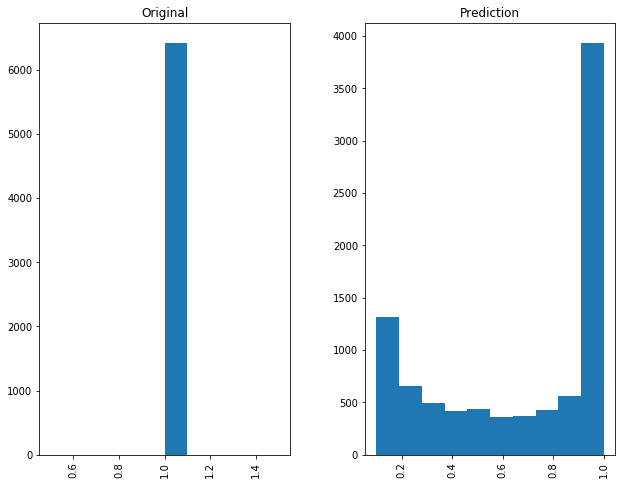

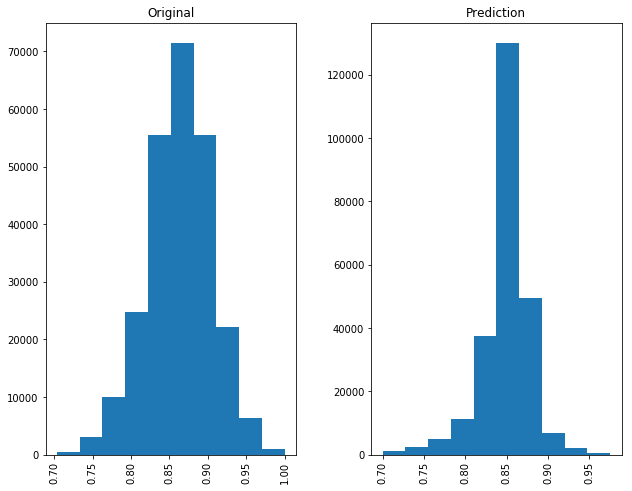

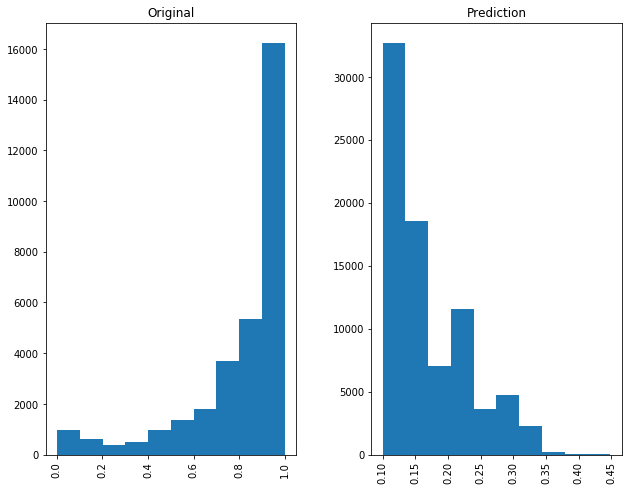

In [27]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'iteration_3_histogram_distribution_' + str(i))
    

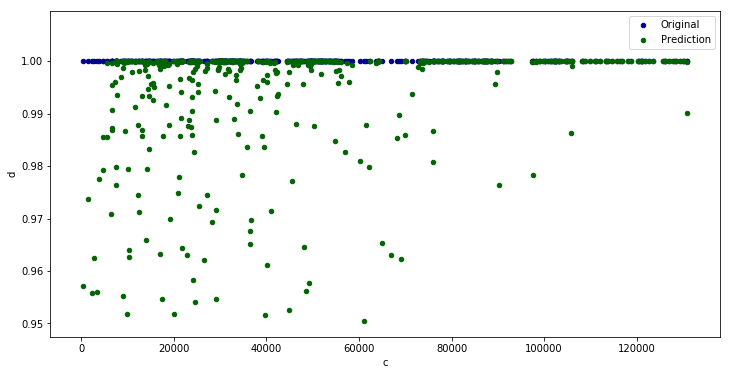

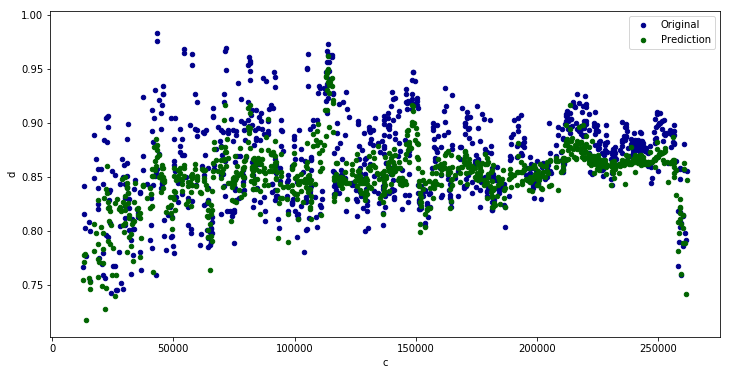

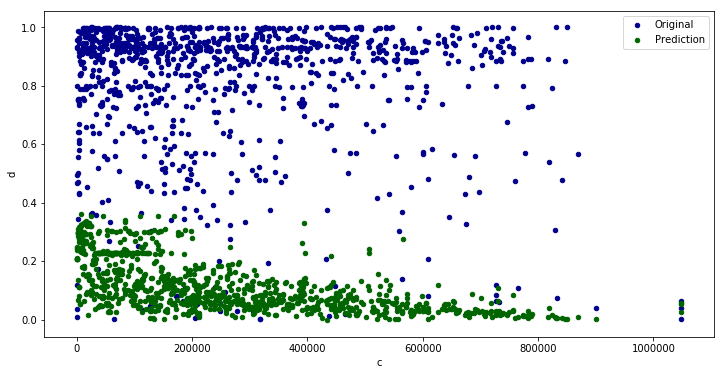

In [28]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'iteration_3_scatter_org_vs_prediction_' + str(i) + '.png')

In [ ]:
if 'model' in locals():
    del model
    
numOfExperiment = 'model_weigth'
graph1 = load_dicty('clustering', 2)
folder = '/home/lpodgorsek/data/cnn/dicty/_10/'

model = MultiModal(graph=graph1, path=folder, load_test_cells=True)
model.load_model(folder, str(numOfExperiment))
model.predictMultiGPU(random=False, gpu=3)

0.0
1.0

0.0
1.0

0.0
1.0
-------------RelationGraph-------------
Gene	1024
3	ann-(1024, 128), expr-(1024, 256), ppi-(1024, 1024)
0	
GO term	128
0	
1	ann-(1024, 128)
Experimental condition	256
0	
1	expr-(1024, 256)

ann	(1024, 128)
expr	(1024, 256)
ppi	(1024, 1024)


In [ ]:
model.predict_hidden_cells()

(1, 1024, 128, 1)
(1, 1024, 256, 1)
(1, 1024, 1024, 1)
0.0
1.0


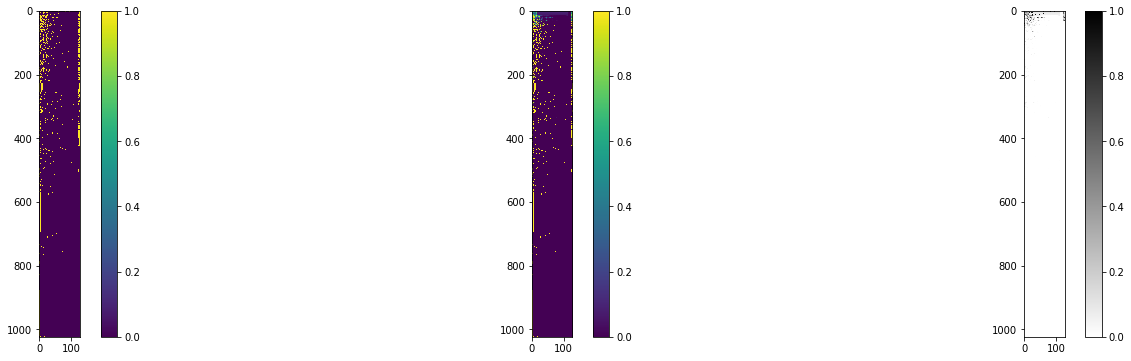

1.5581634e-08
0.987053


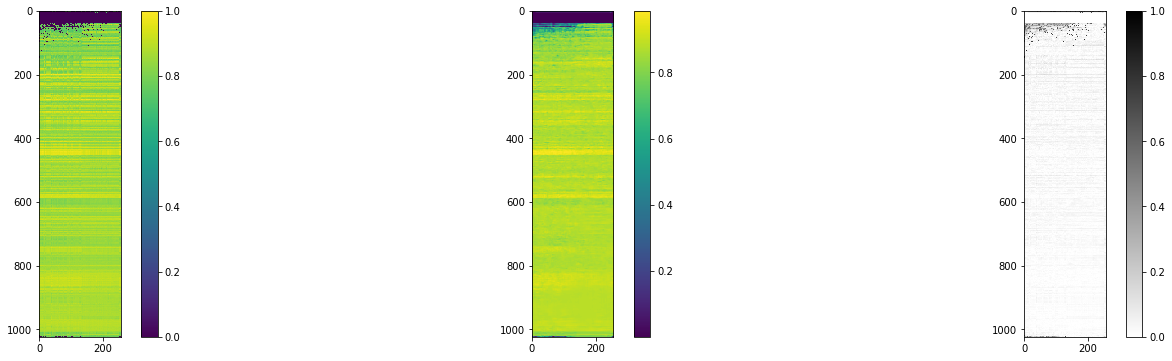

8.839596e-15
0.95211154


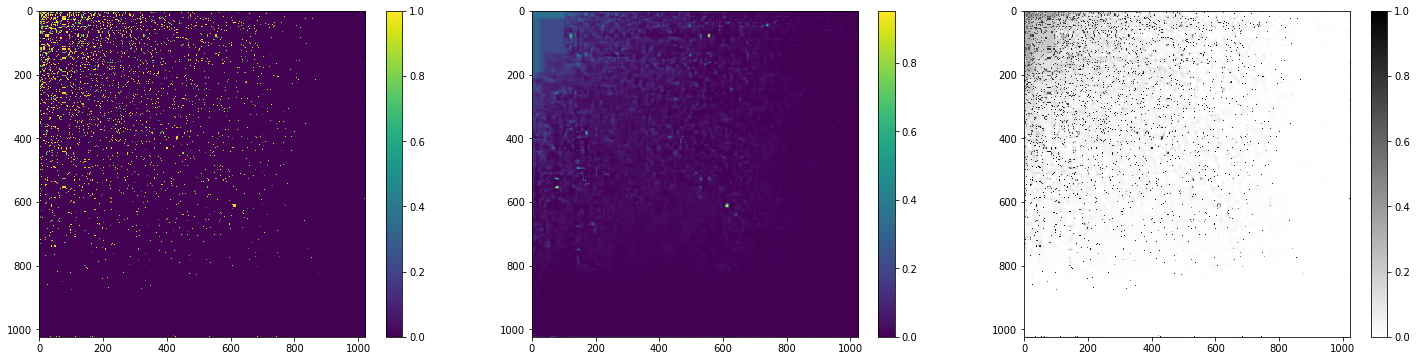

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl

path = '/home/lpodgorsek/mag/Final Results/middle_stage_of_learning_model/'

# color_pack = 'Blues'
# color_pack = 'jet'
color_pack = 'viridis'
color_pack2 = 'viridis'
# color_pack2 = 'RdBu'
color_pack3 = 'binary'
# color_pack = 'PuOr'
# color_pack = 'rainbow'

for i in range(len(model.org_data)):
    l = model.predict_data[i]
    l = np.delete(l, [x for x in range(1,model.predict_data[i].shape[0])], 0)
    print(l.shape)
    model.predict_data[i] = l;

for i in range(len(model.org_data)):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 6))
    _, row, col, _ = model.org_data[i].shape
    org_data = model.org_data[i].reshape((row, col))
    predict = model.predict_data[i].reshape((row, col))
    
    print(np.min(model.predict_data[i]))
    print(np.max(model.predict_data[i]))
    
    
    ax = axes[0]
    im = ax.imshow(org_data, vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack))

    ax = axes[1]
    im2 = ax.imshow(predict, vmin=np.min(predict), vmax=np.max(predict), cmap=plt.cm.get_cmap(color_pack2))

    ax = axes[2]
    im3 = ax.imshow(np.abs(predict - org_data), vmin=0, vmax=1, cmap=plt.cm.get_cmap(color_pack3))
    
    # fig.colorbar(im, ax=axes.ravel().tolist())
#     cax,kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    cax,kw = mpl.colorbar.make_axes([axes[0]])
    cax2,kw2 = mpl.colorbar.make_axes([axes[1]])
    cax3,kw3 = mpl.colorbar.make_axes([axes[2]])
    
    cba = plt.colorbar(im, cax=cax, **kw)
    cbb = plt.colorbar(im2, cax=cax2, **kw2)
    cbc = plt.colorbar(im3, cax=cax3, **kw3)
    
    plt.savefig(path + 'experiment_iteration_4_' + str(numOfExperiment) + '_' + str(i) + '_org_vs_predict.png')

    plt.show()


/home/lpodgorsek/miniconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/plotting/_matplotlib/hist.py:385: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  **kwds


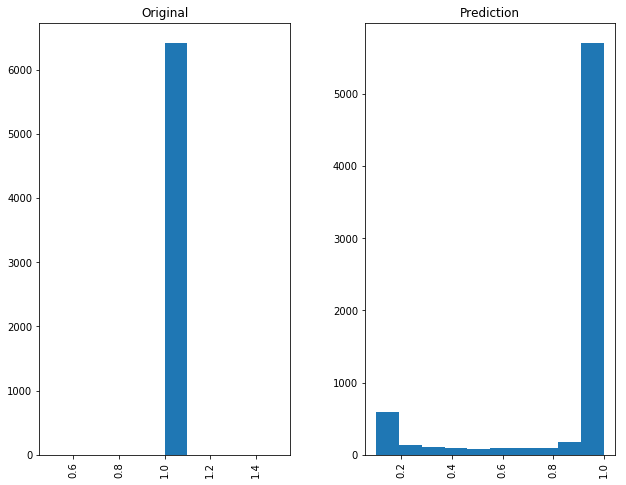

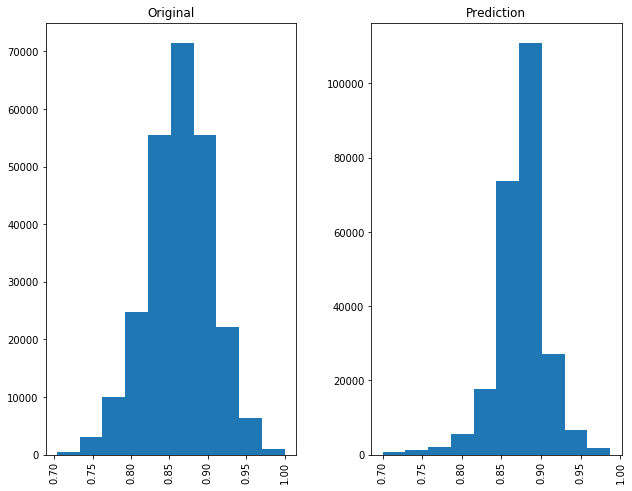

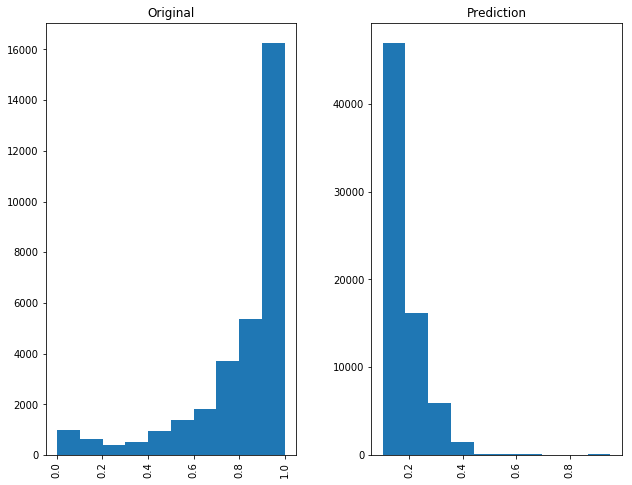

In [23]:
for i in range(len(model.org_data)):
    org_data = model.org_data[i].flatten()
    pred_data = model.predict_data[i].flatten()
    
    data = org_data[org_data > 0]
    indeces = np.zeros(len(org_data[org_data > 0]))
    
    if i == 1:
        data = np.r_[data, pred_data[pred_data > 0.7]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.7]))]
    else:
        data = np.r_[data, pred_data[pred_data > 0.1]]
        indeces = np.r_[indeces, np.ones(len(pred_data[pred_data > 0.1]))]
    
    new_idx = np.where(indeces == 0, 'Original', indeces)
    new_idx = np.where(indeces == 1, 'Prediction', new_idx)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    df = pd.DataFrame(data)
    df.hist(by=new_idx, bins=10, figsize=(10, 8), ax=ax)
    fig.savefig(path + 'iteration_4_histogram_distribution_' + str(i))
    

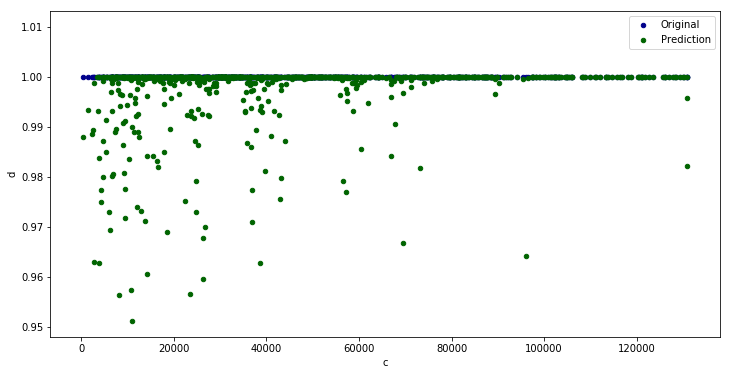

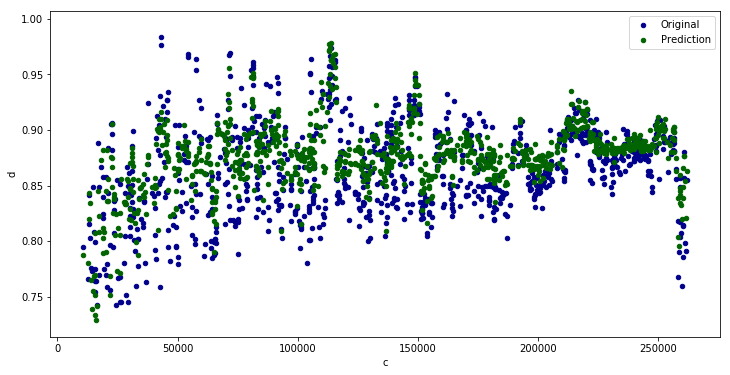

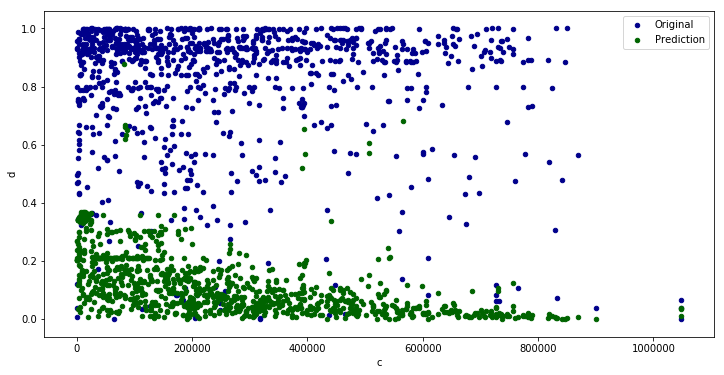

In [24]:
for i in range(len(model.org_data)):
    org_data = model.saved_cells_for_test[i]
    predict_data = model.predict_saved_cells_for_test[i]
    data = []
    for j in range(len(org_data)):
        if i == 0:
            if predict_data[j][1] > 0.95:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        elif i == 1:
            if predict_data[j][1] > 0.7:
                data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])
        else:
            data.append([org_data[j][0], org_data[j][1], predict_data[j][0], predict_data[j][1]])

    df = pd.DataFrame(data, columns=['a', 'b', 'c', 'd'])
    
    fig, ax = plt.subplots(figsize=(12,6))
    ax = df.plot.scatter(x='a', y='b', color='DarkBlue', label='Original', ax=ax);
    ax = df.plot.scatter(x='c', y='d', color='DarkGreen', label='Prediction', ax=ax, figsize=(12,6));
    fig.savefig(path + 'iteration_4_scatter_org_vs_prediction_' + str(i) + '.png')